## IGO15771 - KP Slc4a11-MCD mTmG traced mice
4/1/2024 - Data generated from 14 week KP Slc4a11-MCD mTmG mice traced for 2 weeks; data submitted by CHP/EB on 3/5/2024, analyzed by JC 4/1/2024

8/25/2025 - Rerun with latest libraries for coherence

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import math
import matplotlib

import anndata
from pathlib import Path

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [3]:
#Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [4]:
results_file = 'write/IGO15771-mTmG-12week.h5ad'  # the file that will store the analysis results

In [5]:
adata = sc.read_10x_h5('GSE277777_IGO15771-filtered_feature_bc_matrix.h5', gex_only=False)

reading GSE277777_IGO15771-filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [6]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [7]:
samples = list(adata[:,adata.var['feature_types']=='Antibody Capture'].var.index)

In [8]:
# Now filter out barcodes
hashadata = adata[:,samples]
adata = adata[:,[y for y in adata.var_names if y not in samples]]

In [9]:
hashadata.var

gene_ids     feature_types genome  \
BH1066_GFP+                  BH1066_GFP+  Antibody Capture          
BB1010_mKate+              BB1010_mKate+  Antibody Capture          
BD1870_Epcam+              BD1870_Epcam+  Antibody Capture          
BH1719_Live+Immune-  BH1719_Live+Immune-  Antibody Capture          

                                       pattern read         sequence  
BH1066_GFP+          5PNNNNNNNNNN(BC)NNNNNNNNN   R2  ACCCACCAGTAAGAC  
BB1010_mKate+        5PNNNNNNNNNN(BC)NNNNNNNNN   R2  GGTCGAGAGCATTCA  
BD1870_Epcam+        5PNNNNNNNNNN(BC)NNNNNNNNN   R2  CTTGCCGCATGTCAT  
BH1719_Live+Immune-  5PNNNNNNNNNN(BC)NNNNNNNNN   R2  AAAGCATTCTTCACG

## Preprocessing

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


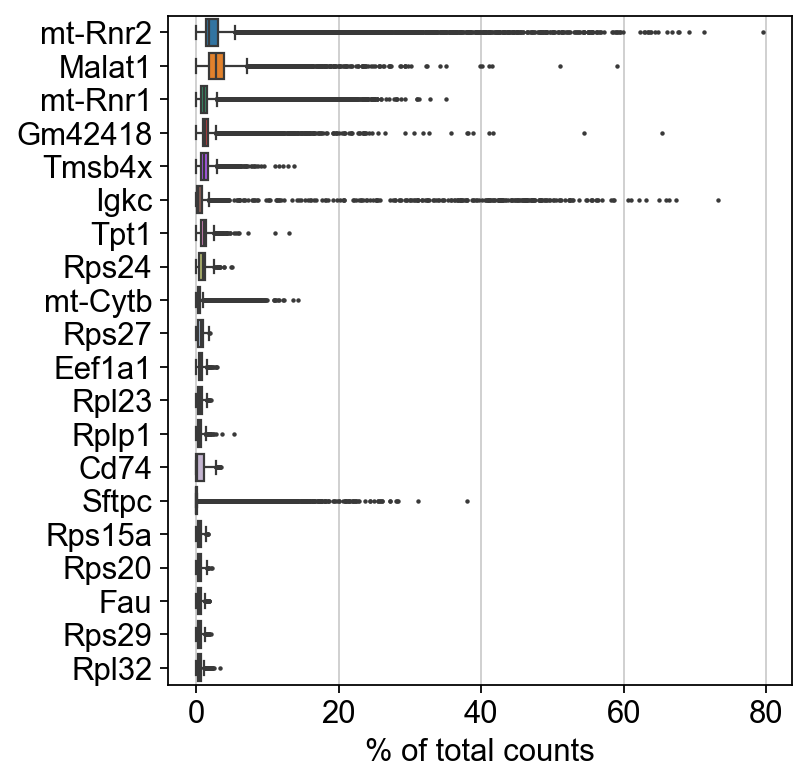

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering:

In [11]:
sc.pp.filter_cells(adata, min_counts=1500)
sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1708 cells that have less than 1500 counts
filtered out 79 cells that have less than 300 genes expressed
filtered out 30673 genes that are detected in less than 3 cells


In [12]:
adata.var['mt'] = adata.var_names.str.startswith('mt-') # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

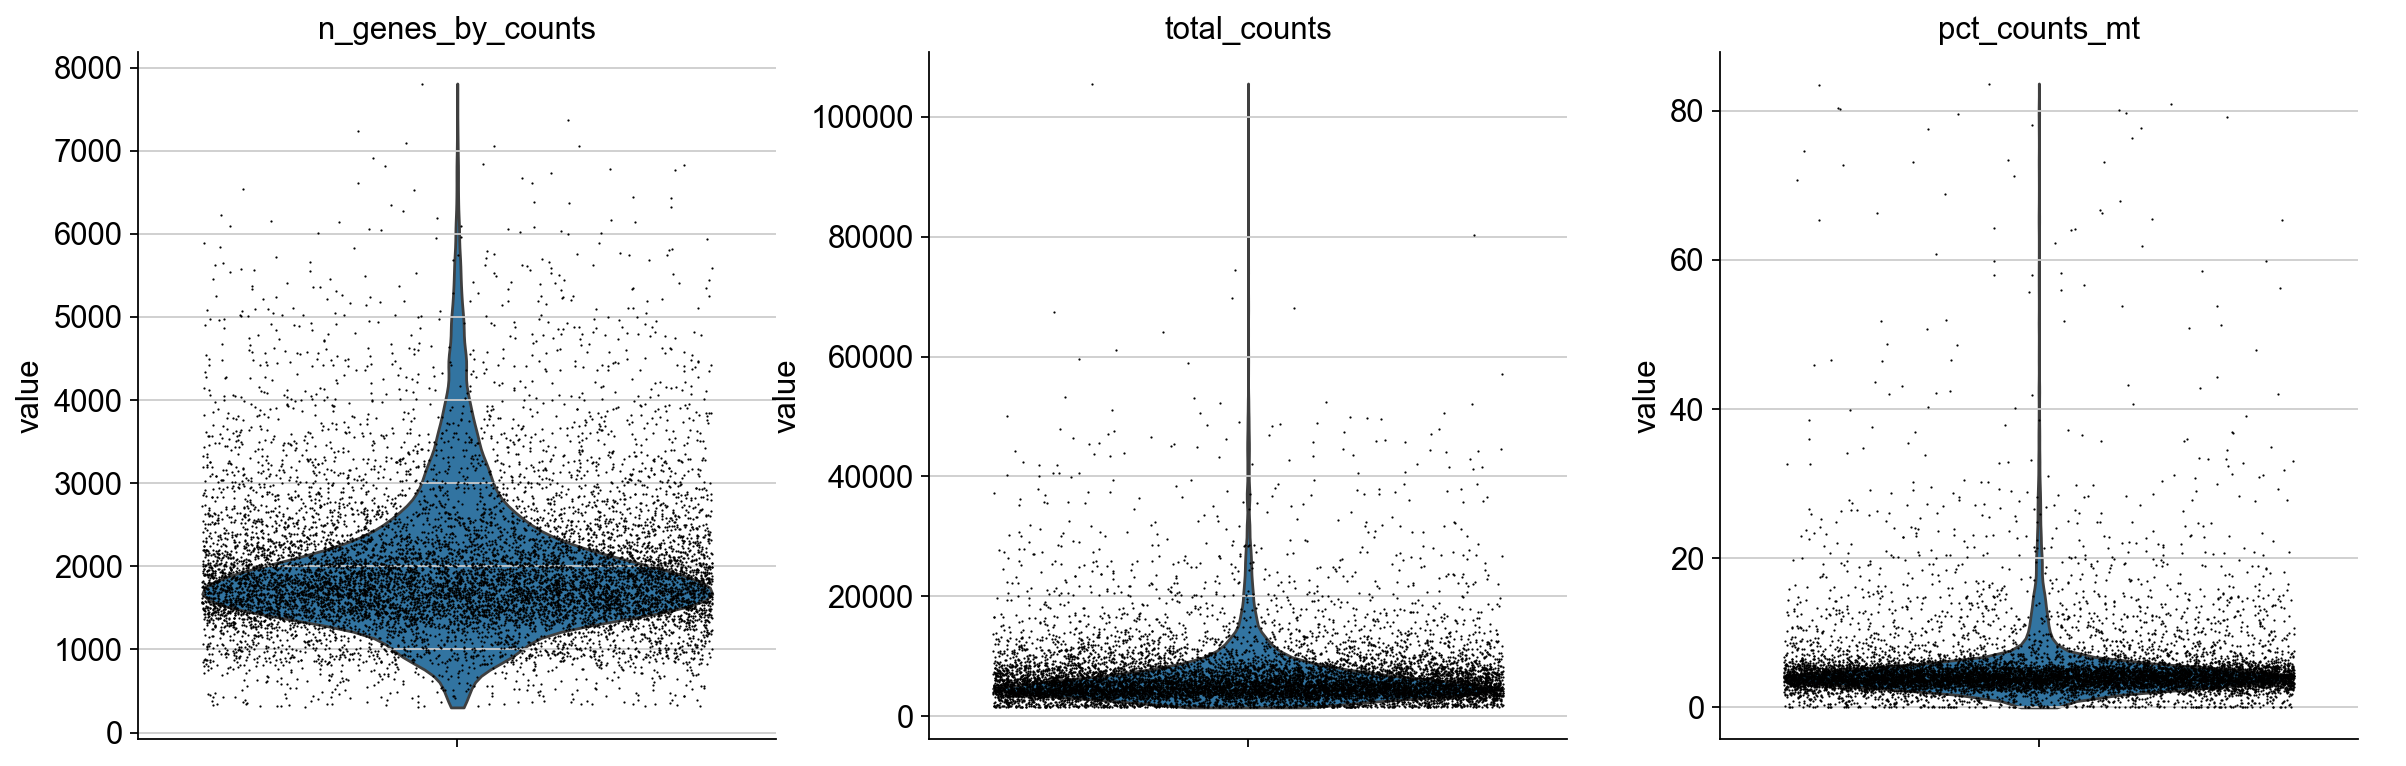

In [13]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True, rotation=90)

(array([4.000e+00, 1.300e+01, 5.900e+01, 9.400e+01, 1.030e+02, 1.830e+02,
        1.109e+03, 5.210e+03, 3.459e+03, 6.700e+02]),
 array([0.6674297 , 0.69424954, 0.72106939, 0.74788923, 0.77470907,
        0.80152891, 0.82834875, 0.8551686 , 0.88198844, 0.90880828,
        0.93562812]),
 <BarContainer object of 10 artists>)

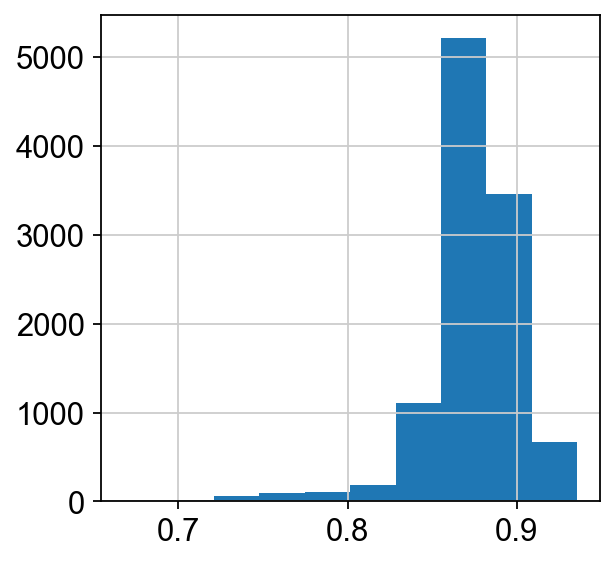

In [14]:
adata.obs["log10GenesPerUMI"] = adata.obs['n_genes_by_counts'].apply(math.log10) / adata.obs['total_counts'].apply(math.log10)
matplotlib.pyplot.hist(adata.obs["log10GenesPerUMI"])

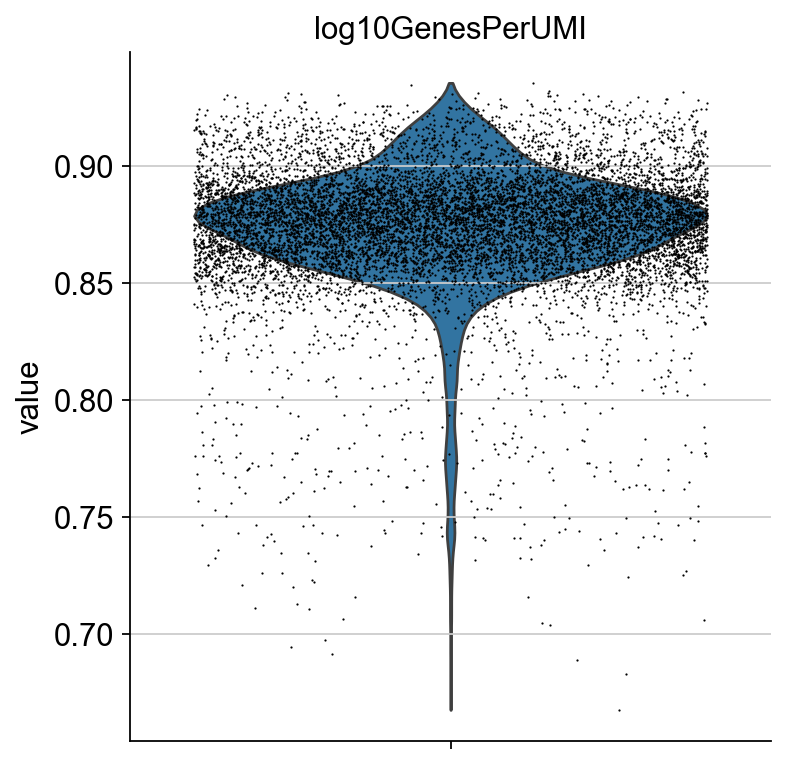

In [15]:
sc.pl.violin(adata, ['log10GenesPerUMI'],
             jitter=0.4, multi_panel=True, rotation=90)

Keep singlets, remove cells that have too many mouse reads, or mitochondrial genes expressed or too many total counts:

In [16]:
#Filter by Log10GenesPerUMI
adata = adata[adata.obs.log10GenesPerUMI >= 0.8,:]

In [17]:
adata = adata[adata.obs.pct_counts_mt <= 20, :]

## Run Demultiplexing

In [18]:
hashadata = hashadata[hashadata.obs.index.isin(adata.obs.index), :]

In [19]:
hashadata.var_names

Index(['BH1066_GFP+', 'BB1010_mKate+', 'BD1870_Epcam+', 'BH1719_Live+Immune-'], dtype='object')

In [20]:
hashCounts = pd.DataFrame(hashadata.X.todense(), columns=hashadata.var_names, index=adata.obs.index)

In [21]:
hashDisc = hashCounts.describe([.1,.2,.3,.4,.5,.6,.7,.8,.9,0.99])
hashDisc

BH1066_GFP+  BB1010_mKate+  BD1870_Epcam+  BH1719_Live+Immune-
count  10418.000000   10418.000000   10418.000000         10418.000000
mean     141.269913      68.922920     183.249084          1695.622559
std      752.877075     569.707214     980.754395          1164.908813
min        0.000000       0.000000       0.000000             2.000000
10%        5.000000       3.000000       2.000000            86.700000
20%        7.000000       5.000000       3.000000           894.800000
30%        8.000000       6.000000       4.000000          1206.000000
40%        9.000000       7.000000       5.000000          1403.800000
50%       10.000000       8.000000       6.000000          1583.000000
60%       12.000000       9.000000       7.000000          1793.000000
70%       13.000000      11.000000       9.000000          2041.900000
80%       16.000000      13.000000      12.000000          2372.000000
90%       22.000000      19.000000      23.000000          2990.000000
99%     4150.940000    1565.770000    5957.790000          5596.130000
max    24650.000000   24191.000000   14956.000000         20602.000000

In [22]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(hashDisc.loc["90%",hashName])
    hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
#hashIDs

BH1066_GFP+
22.0
BB1010_mKate+
19.0
BD1870_Epcam+
23.0
BH1719_Live+Immune-
2990.0


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ True False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = hashCounts.loc[:,hashName] > hashDisc.loc["90%",hashName]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/4170078627.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise 

In [23]:
from matplotlib import pyplot as plt

In [24]:
hashCounts

BH1066_GFP+  BB1010_mKate+  BD1870_Epcam+  \
AAACCCAAGCAACAAT-1         27.0            9.0           11.0   
AAACCCAAGCTATCTG-1         12.0           11.0            7.0   
AAACCCAAGCTTAGTC-1          4.0            3.0           11.0   
AAACCCACAATTCTCT-1         11.0            9.0            6.0   
AAACCCACACCCTTGT-1          9.0            9.0            6.0   
...                         ...            ...            ...   
TTTGTTGCAAATCGTC-1         11.0            6.0            4.0   
TTTGTTGCAAGTCGTT-1         13.0            5.0            9.0   
TTTGTTGCATAAGATG-1         15.0           13.0            8.0   
TTTGTTGCATCTCATT-1         14.0           13.0            9.0   
TTTGTTGTCTCTCTTC-1          8.0            9.0            7.0   

                    BH1719_Live+Immune-  
AAACCCAAGCAACAAT-1               1329.0  
AAACCCAAGCTATCTG-1               2180.0  
AAACCCAAGCTTAGTC-1                776.0  
AAACCCACAATTCTCT-1                863.0  
AAACCCACACCCTTGT-1               3322.0  
...                                 ...  
TTTGTTGCAAATCGTC-1               1368.0  
TTTGTTGCAAGTCGTT-1               3452.0  
TTTGTTGCATAAGATG-1               1977.0  
TTTGTTGCATCTCATT-1               1704.0  
TTTGTTGTCTCTCTTC-1               1147.0  

[10418 rows x 4 columns]

In [25]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"
plt.rcParams['figure.figsize'] = (3,4)

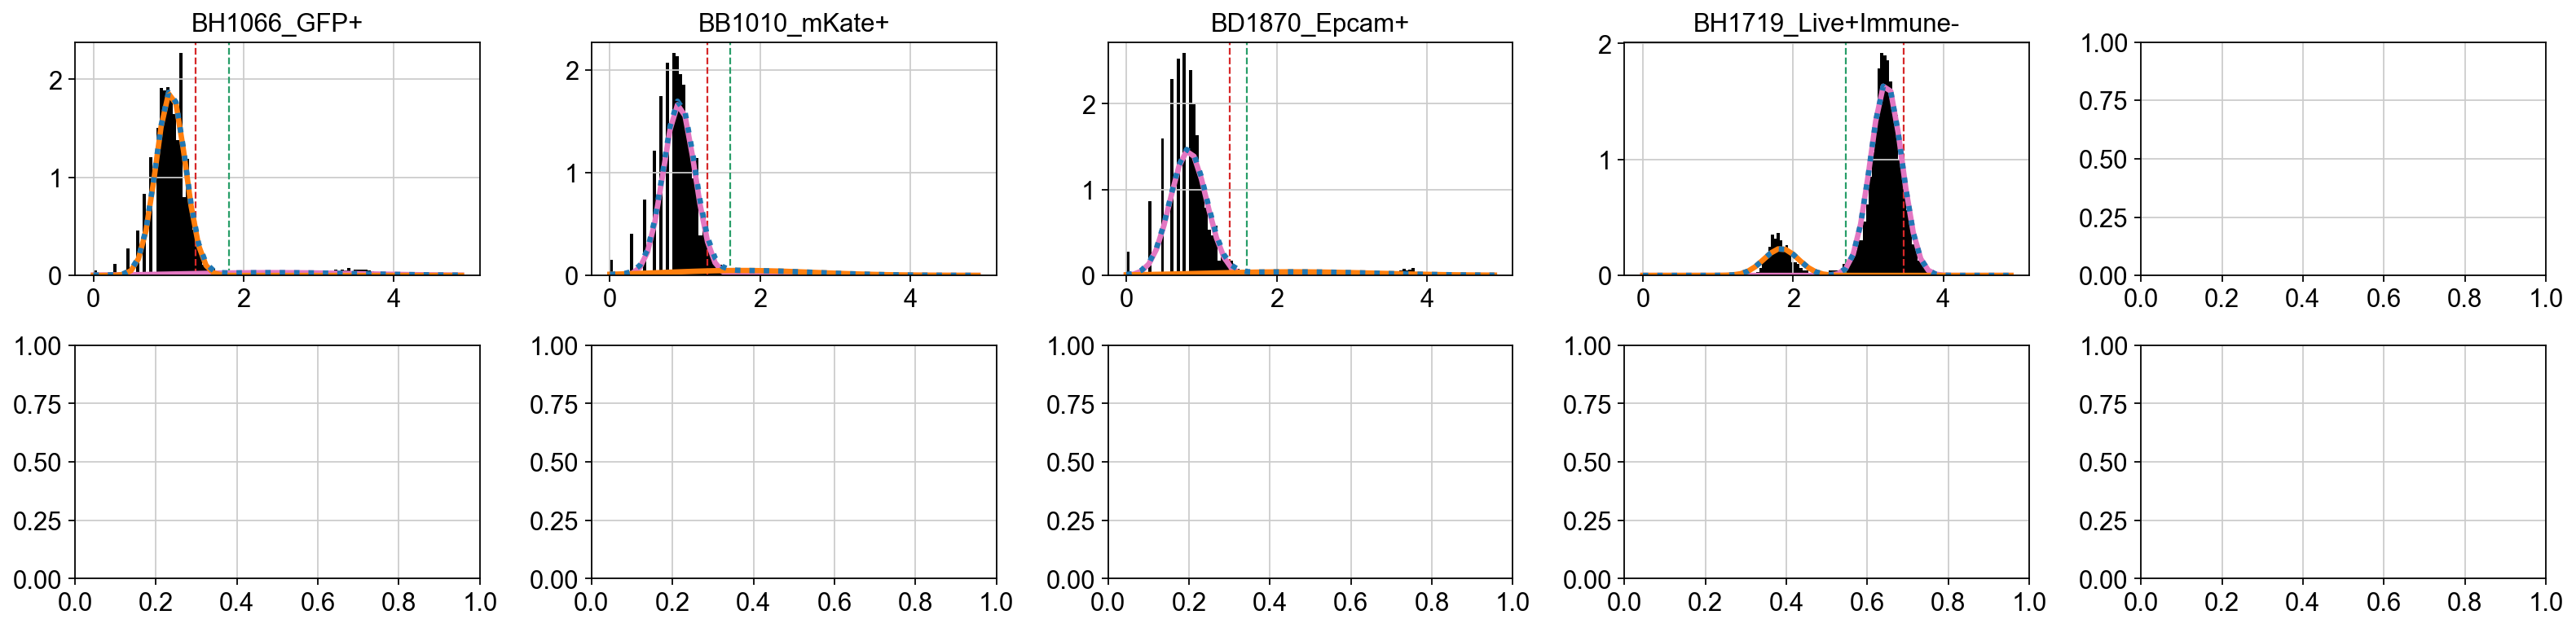

In [26]:
from sklearn.mixture import BayesianGaussianMixture
from scipy.stats import norm
fig, axs = plt.subplots(2,5, figsize =(20, 5))
dfHashBoundry = pd.DataFrame(np.zeros(len(hashadata.var_names)),hashadata.var_names, columns=["boundry"])
gmm = BayesianGaussianMixture(n_components=2, random_state=250,init_params='k-means++')
binEx = np.arange(0,5,5/100).reshape(-1,1)

for i, hashName in enumerate(hashadata.var_names):
    hashCount = np.array(np.log10(hashCounts[hashName]+1)).reshape(-1, 1)
    fitGMM = gmm.fit(hashCount)
    mean = fitGMM.means_  
    covs  = fitGMM.covariances_
    weights = fitGMM.weights_
  
    fitGmmBound = fitGMM.predict(binEx)

    x_axis = np.arange(0, 5, 0.1)
    y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
    y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

    hashBoundry = False #binEx[np.where(fitGmmBound == 1)[0][0]][0]    
    if mean[0][0] < mean[1][0]:
        hashBoundry = x_axis[np.where(y_axis1 < y_axis0)[0][-1]+2]
    else:
        hashBoundry = x_axis[np.where(y_axis0 < y_axis1)[0][-1]+2]
    
    naiveBoundry = np.log10(int(hashDisc.loc["90%",hashName])+1)
    
    dfHashBoundry.loc[hashName] = hashBoundry
    
    # Plot 2
    axs[i//5,i%5].set_title(hashName)
    axs[i//5,i%5].axvline(naiveBoundry, c='C3', linestyle='dashed', linewidth=1) #red
    axs[i//5,i%5].axvline(hashBoundry, c='C2', linestyle='dashed', linewidth=1)  #green
    axs[i//5,i%5].hist(hashCount, density=True, color='black', bins=100)        
    axs[i//5,i%5].plot(x_axis, y_axis0, lw=3, c='C6')                            #pink
    axs[i//5,i%5].plot(x_axis, y_axis1, lw=3, c='C1')                            #orange
    axs[i//5,i%5].plot(x_axis, y_axis0+y_axis1, lw=3, c='C0', ls=':')            #dotted blue
    
plt.tight_layout(pad=1.0)
#plt.rcParams["figure.figsize"] = (20,5)
plt.show()

In [27]:
hashIDs = hashCounts.copy()
hashID = hashadata.var_names
for hashName in hashadata.var_names:
    print(hashName)
    print(dfHashBoundry.loc[hashName].values[0])
    hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
#hashIDs

BH1066_GFP+
1.8
BB1010_mKate+
1.6
BD1870_Epcam+
1.6
BH1719_Live+Immune-
2.7


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/416796475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/416796475.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[False False False ... False False False]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  hashIDs.loc[:,hashName] = np.log10(hashCounts.loc[:,hashName]+1) > dfHashBoundry.loc[hashName].values[0]
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/416796475.py:6: FutureWarning: Setting an item of incompati

In [28]:
classification = np.empty(len(adata), dtype="object")
i = 0
for cellBar, hashBool in hashIDs.iterrows():
    numHashes = sum(hashBool)
    if (numHashes == 1):
        classif = hashID[hashBool.values].values[0]
    elif (numHashes > 1):
        classif = "doublet"
    else:
        classif = "negative"
    classification[i] = classif
    i = i + 1
    #break

In [29]:
adata.obs["Classification"] = classification
hashadata.obs["Classification"] = classification
adata.obs["Classification"].value_counts()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/4135005838.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["Classification"] = classification
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/4135005838.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  hashadata.obs["Classification"] = classification


Classification
BH1719_Live+Immune-    8121
doublet                 879
BD1870_Epcam+           426
negative                344
BH1066_GFP+             342
BB1010_mKate+           306
Name: count, dtype: int64

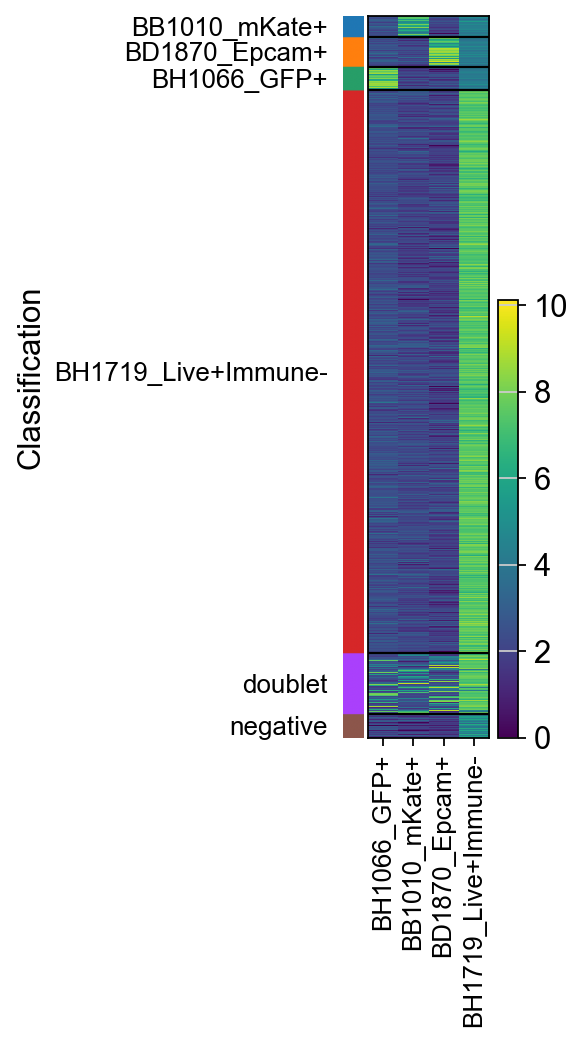

In [30]:
#output visulaization of hashing
sc.pl.heatmap(hashadata, hashadata.var_names, groupby="Classification", log=True)#, save = f"_{figName}_hash.png")

## set transgenes counts

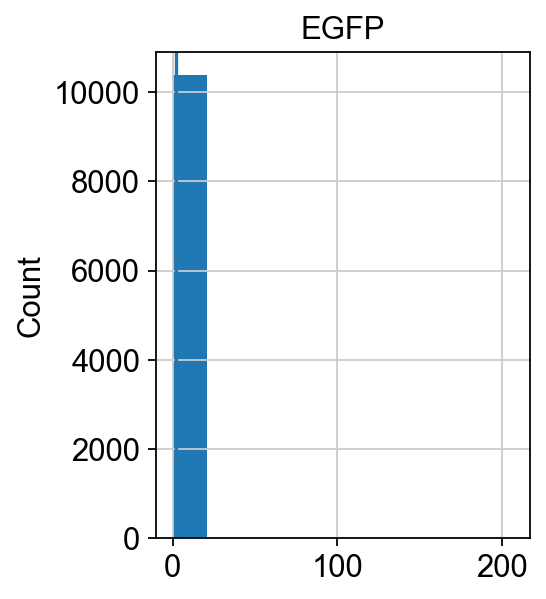

In [31]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['EGFP'])].toarray())
plt.ylabel("Count")
plt.title("EGFP")
plt.axvline(x=2)
plt.show()

In [32]:
adata.obs['EGFP_count'] = adata.X[:,adata.var.index.isin(['EGFP'])].toarray()

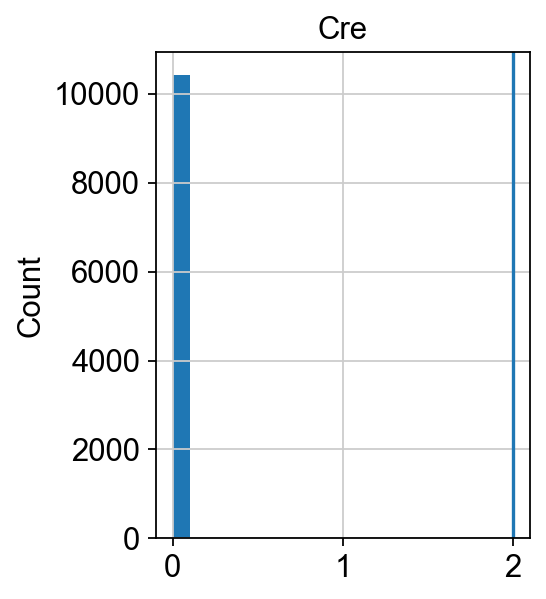

In [33]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['Cre'])].toarray())
plt.ylabel("Count")
plt.title("Cre")
plt.axvline(x=2)
plt.show()

In [34]:
adata.obs['Cre_count'] = adata.X[:,adata.var.index.isin(['Cre'])].toarray()

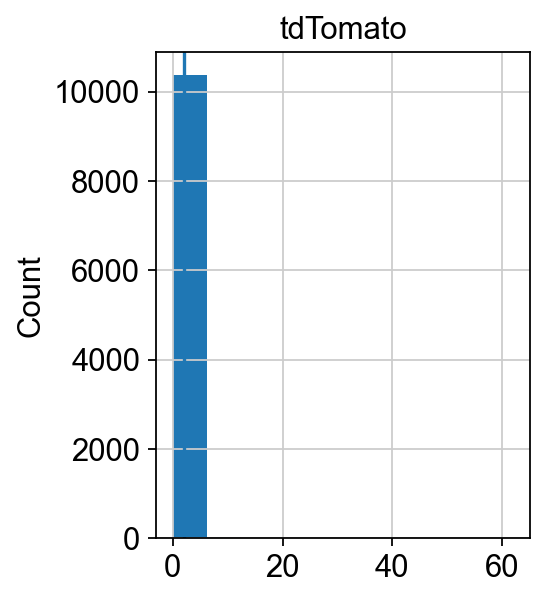

In [35]:
import matplotlib.pyplot as plt
_ = plt.hist(adata.X[:,adata.var.index.isin(['tdTomato'])].toarray())
plt.ylabel("Count")
plt.title("tdTomato")
plt.axvline(x=2)
plt.show()

In [36]:
adata.obs['tdTomato_count'] = adata.X[:,adata.var.index.isin(['tdTomato'])].toarray()

## Filter doublets and negative cells

In [37]:
adata.obs.Classification.value_counts()

Classification
BH1719_Live+Immune-    8121
doublet                 879
BD1870_Epcam+           426
negative                344
BH1066_GFP+             342
BB1010_mKate+           306
Name: count, dtype: int64

In [38]:
adata = adata[~adata.obs['Classification'].isin(['doublet','negative']),:]

In [39]:
adata.obs.Classification.value_counts()

Classification
BH1719_Live+Immune-    8121
BD1870_Epcam+           426
BH1066_GFP+             342
BB1010_mKate+           306
Name: count, dtype: int64

## Run basic normalization

In [40]:
adata.layers['counts']=adata.X.copy()

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/1857676282.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers['counts']=adata.X.copy()


In [41]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


Logarithmize the data:

In [42]:
sc.pp.log1p(adata)

In [43]:
sc.pp.highly_variable_genes(adata) #batch_key=Classification

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


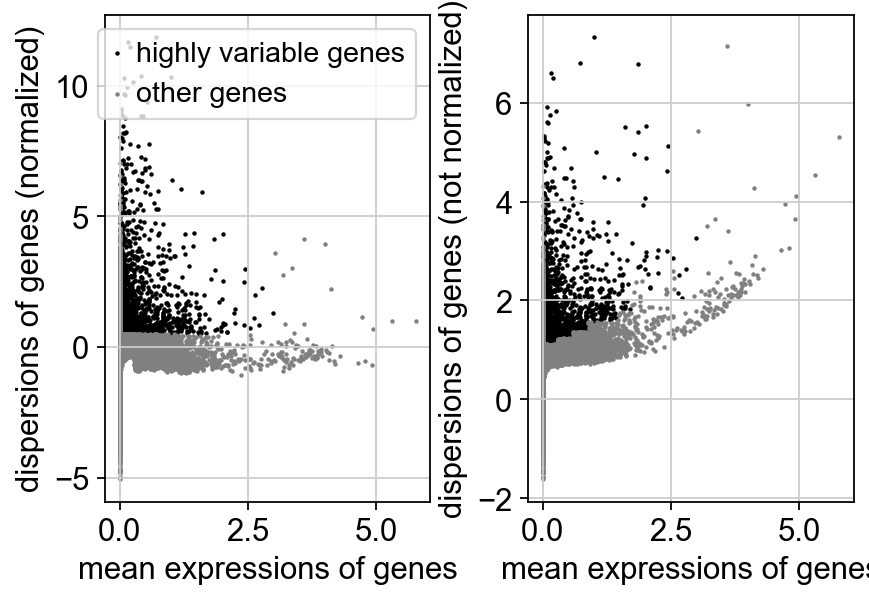

In [44]:
sc.pl.highly_variable_genes(adata)

In [45]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['tagBFP'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/850513103.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/8505131

In [46]:
adata.write('write/allmice-IGO15771.h5ad', compression='gzip')

In [47]:
sc.pp.scale(adata, max_value=10)

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [48]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:04)


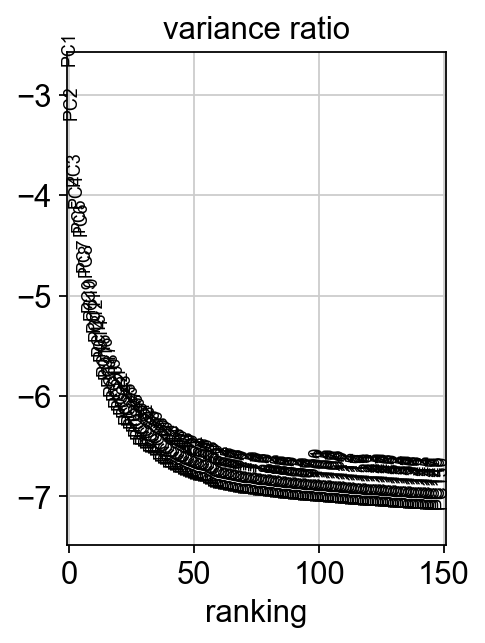

In [49]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=150)

Save the result.

In [50]:
adata.write(results_file, compression='gzip')

## Computing the neighborhood graph

In [51]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)


## Embedding the neighborhood graph

In [52]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:12)


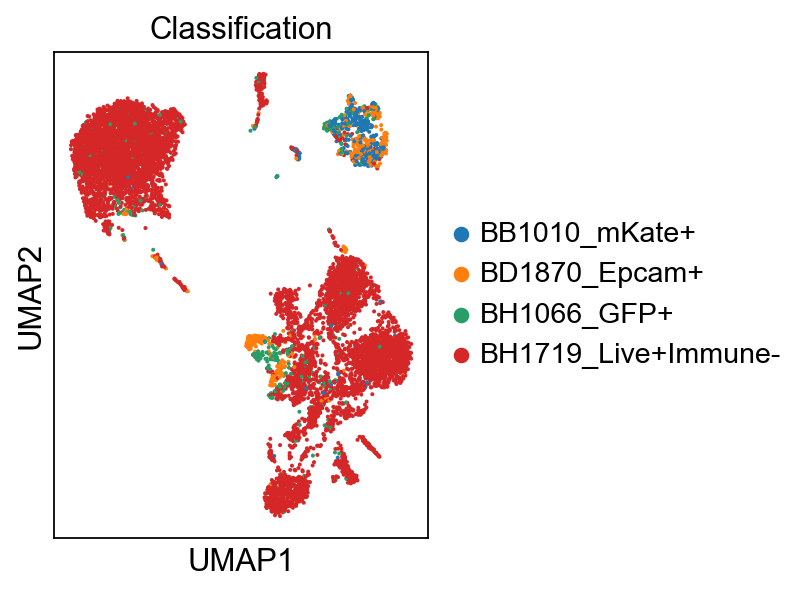

In [53]:
sc.pl.umap(adata, color=['Classification'])

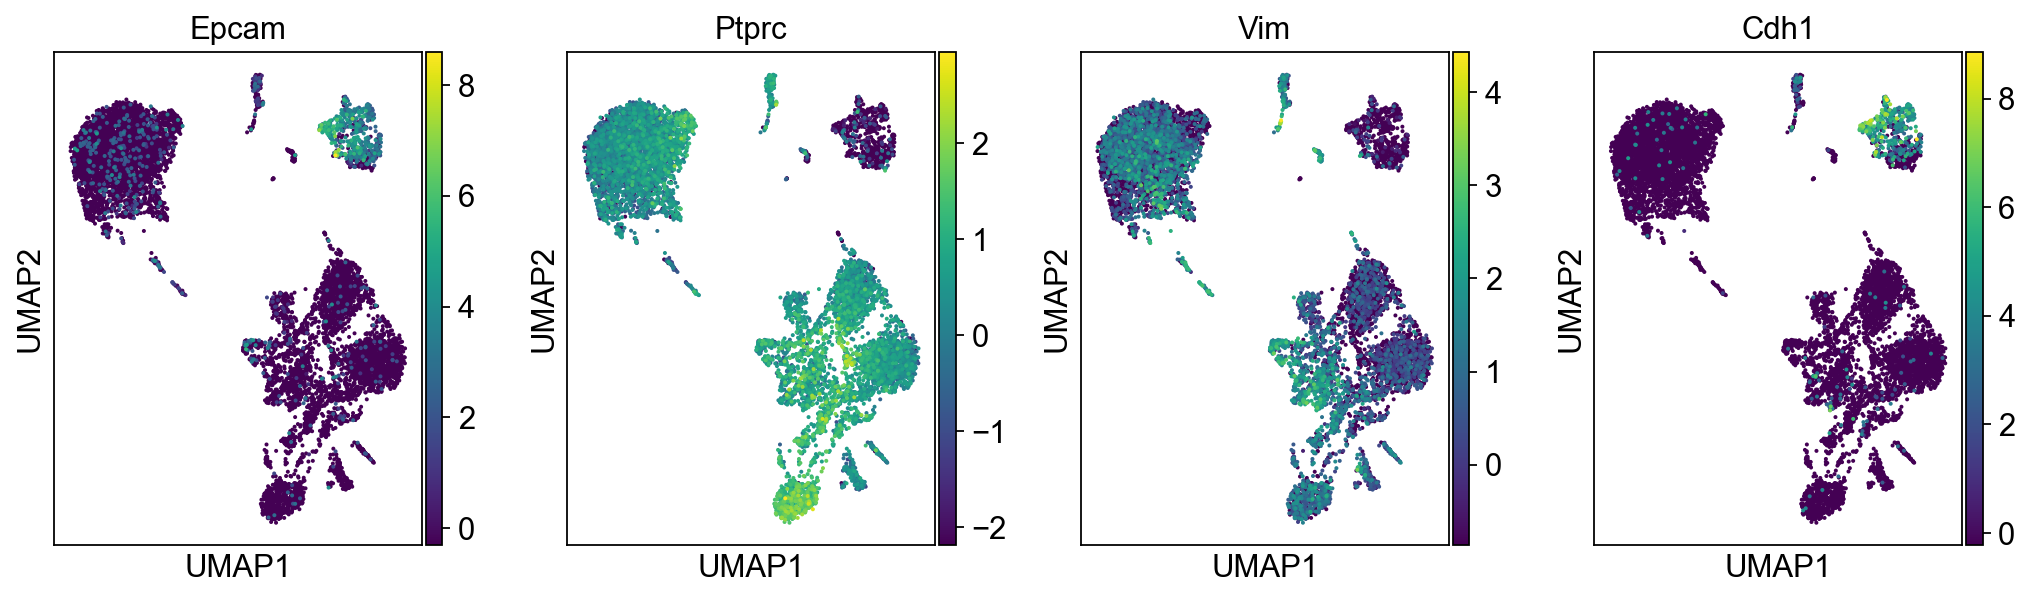

In [54]:
sc.pl.umap(adata, color=['Epcam','Ptprc','Vim', 'Cdh1',]) #'Ptprc','Cdh2'

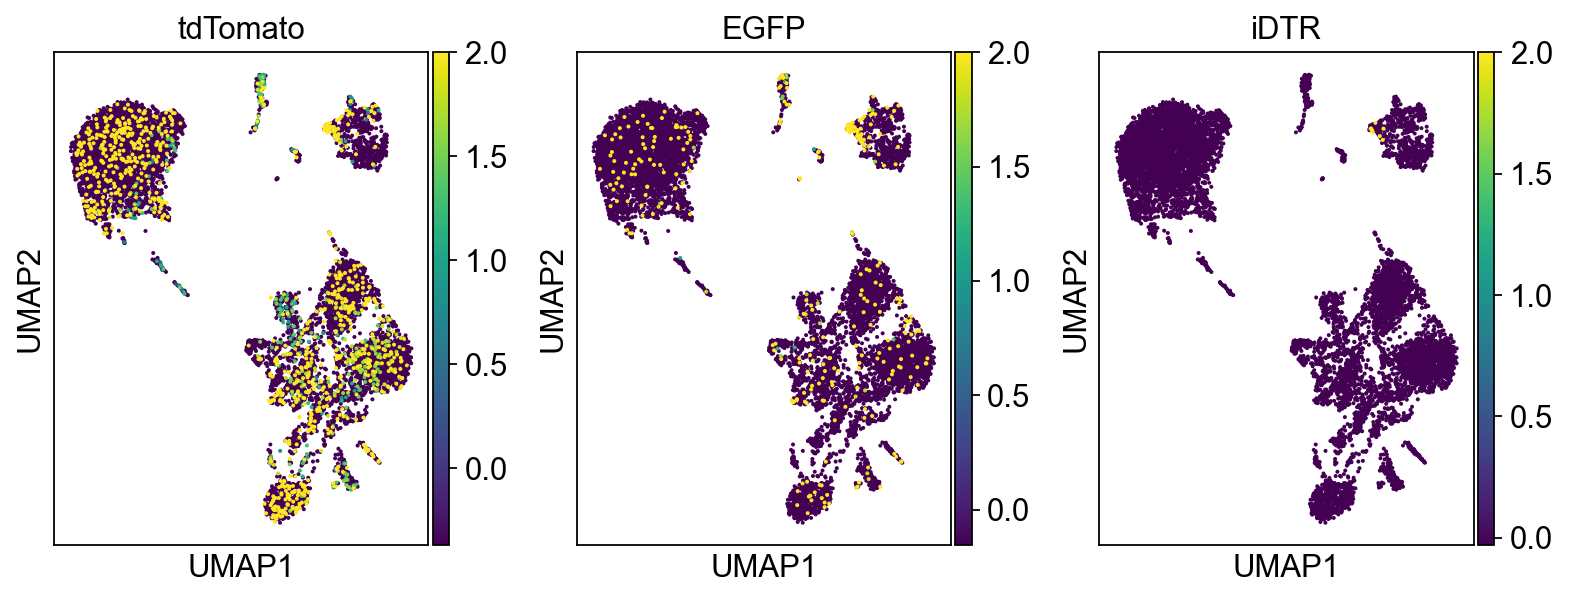

In [55]:
sc.pl.umap(adata, color=['tdTomato','EGFP','iDTR'], vmax=2) #,'mScarlet'

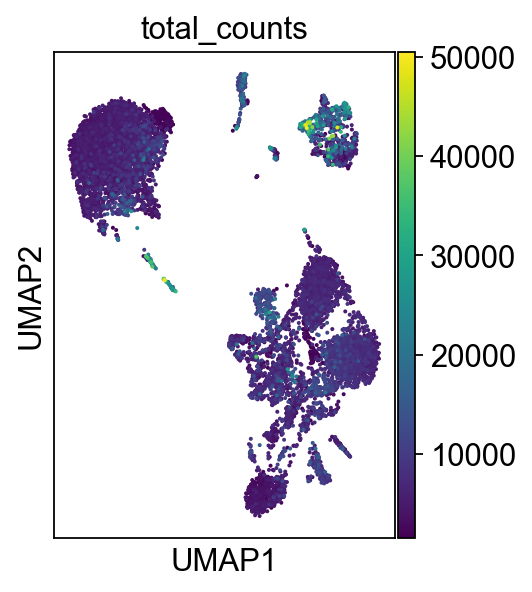

In [56]:
sc.pl.umap(adata, color=['total_counts'])

## Define scoring Functions

In [57]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [58]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=500,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes)  
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [59]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
        #sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    2390 total control genes are used. (0:00:02)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1894 total control genes are used. (0:00:01)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    2090 total control genes are used. (0:00:01)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    2094 total control genes are used. (0:00:02)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    2084 total control genes are used. (0:00:01)
computing score 'Cluster 6'
       'Gm6139', 'Gm10179', 'Ldha-ps2', 'Gm5864'],
      dtype='object')
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    2194 total control genes are used. (0:00:02)
computing score 'Cluster 7'
    finished: added
    'Clus

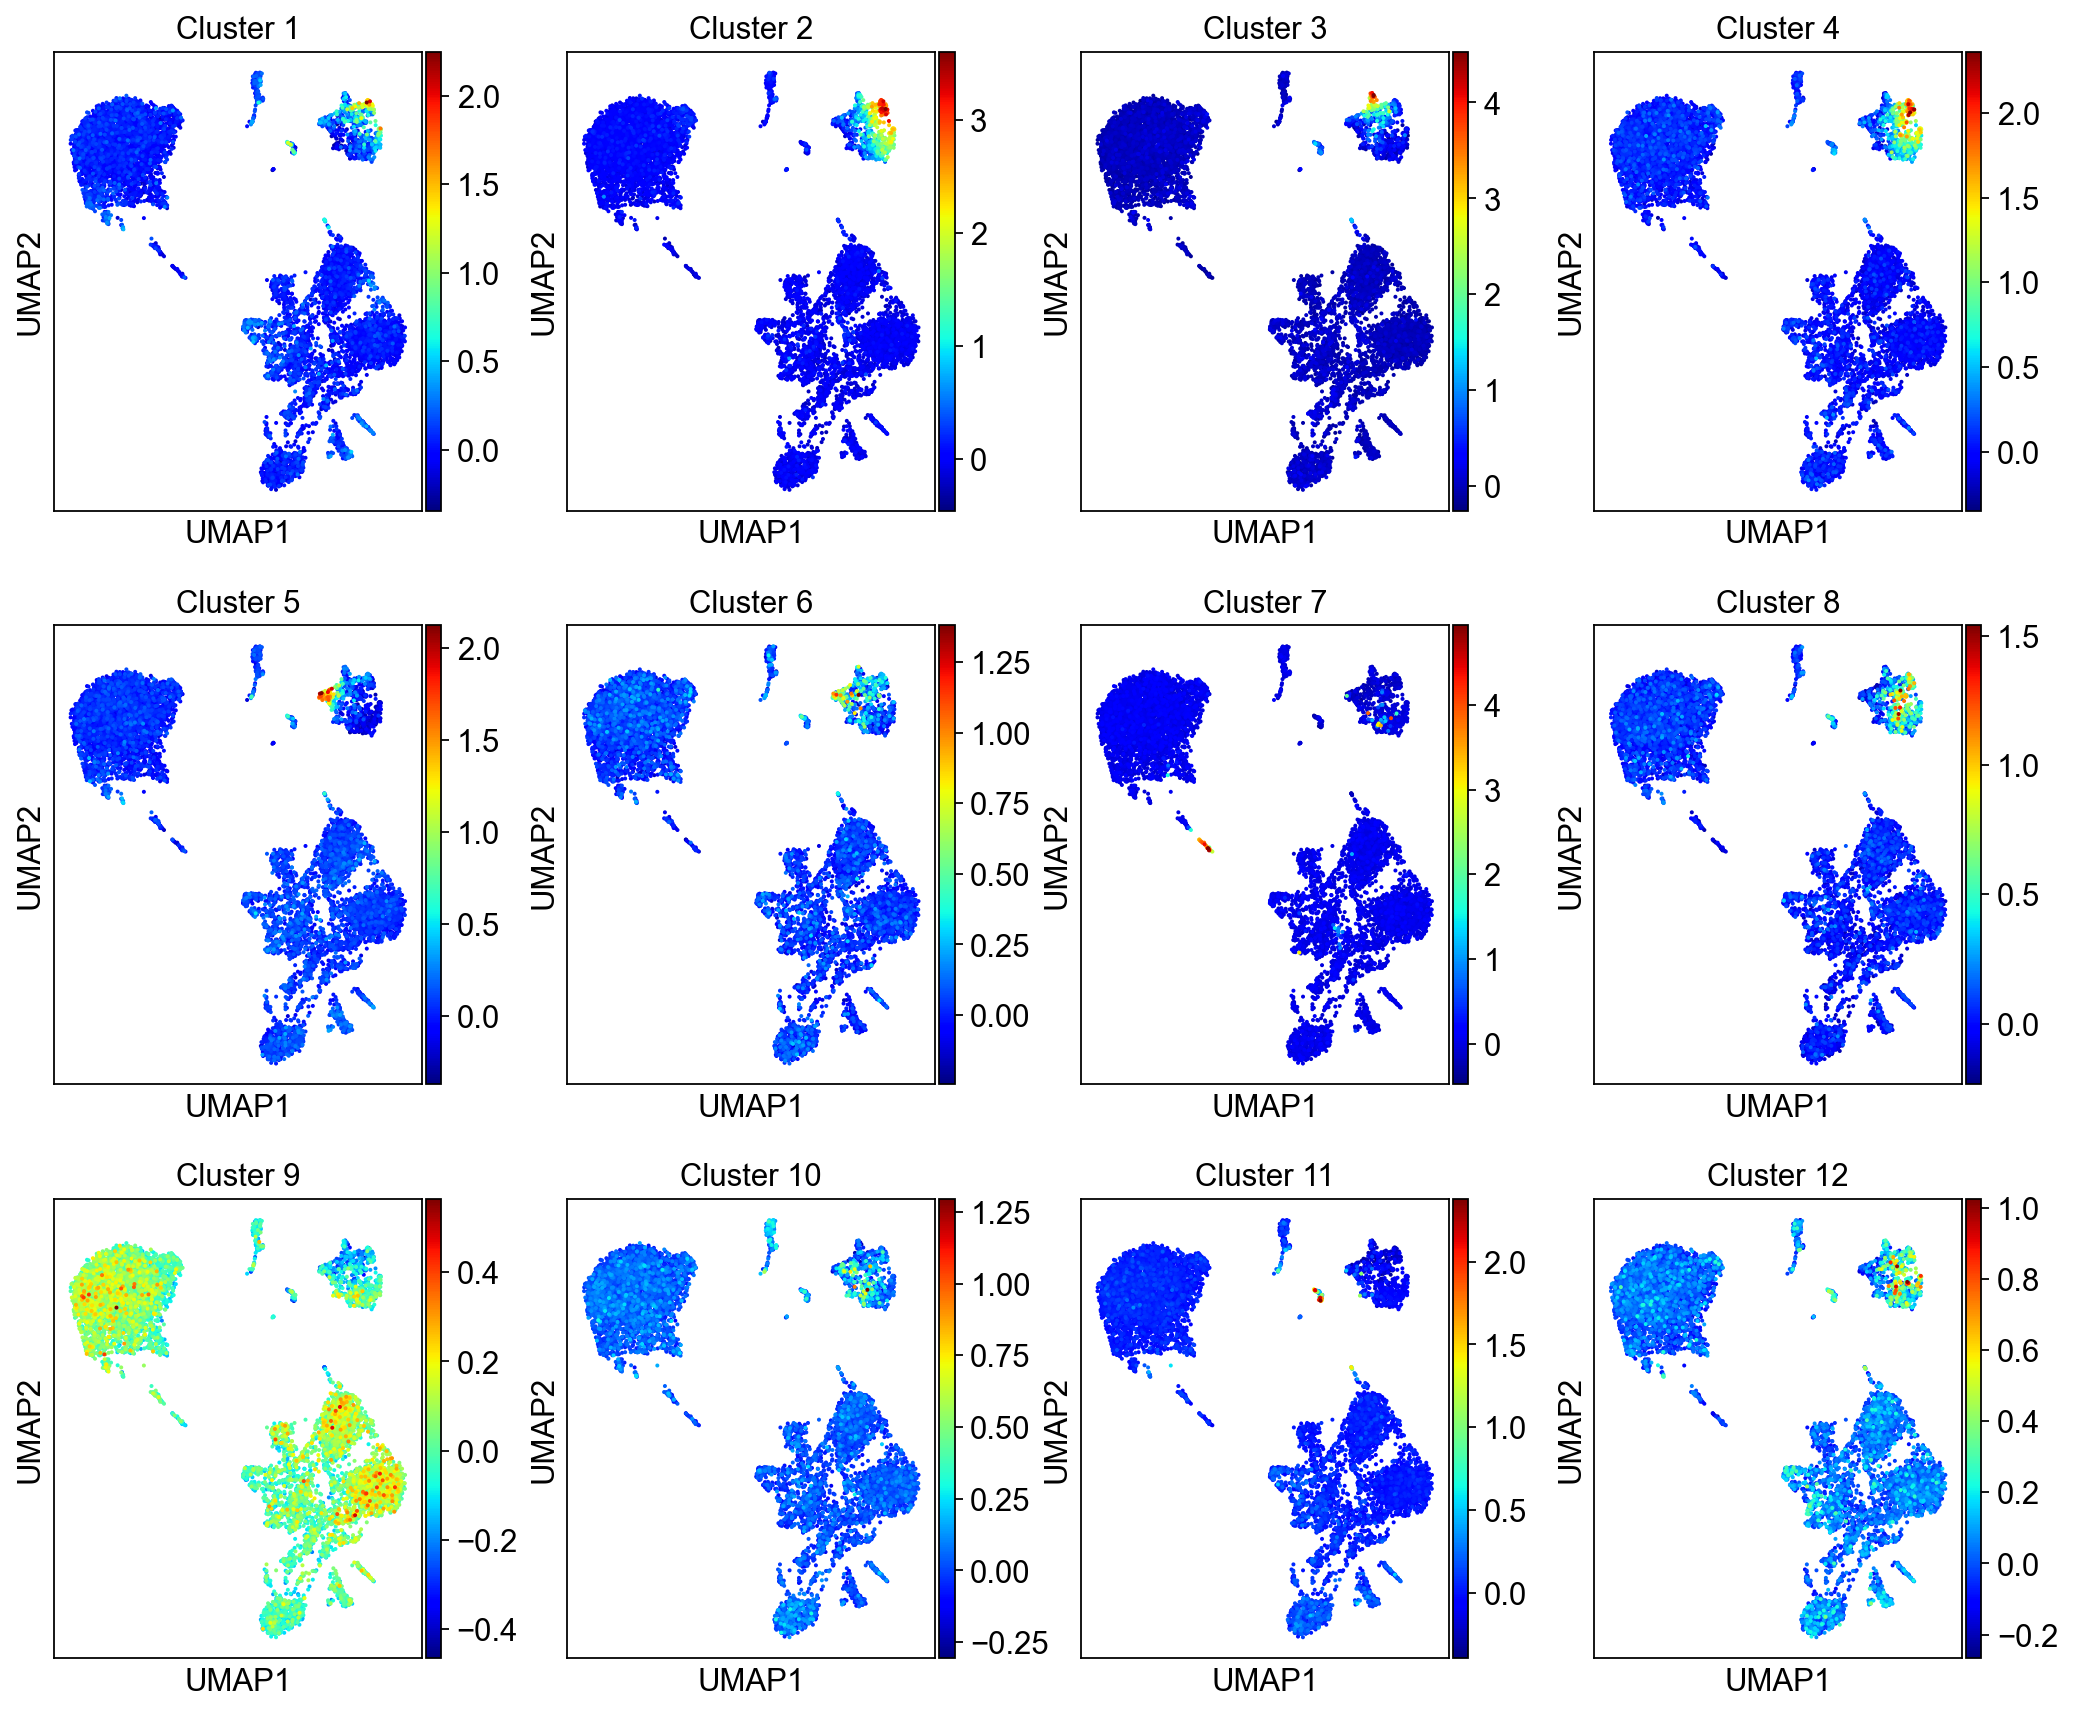

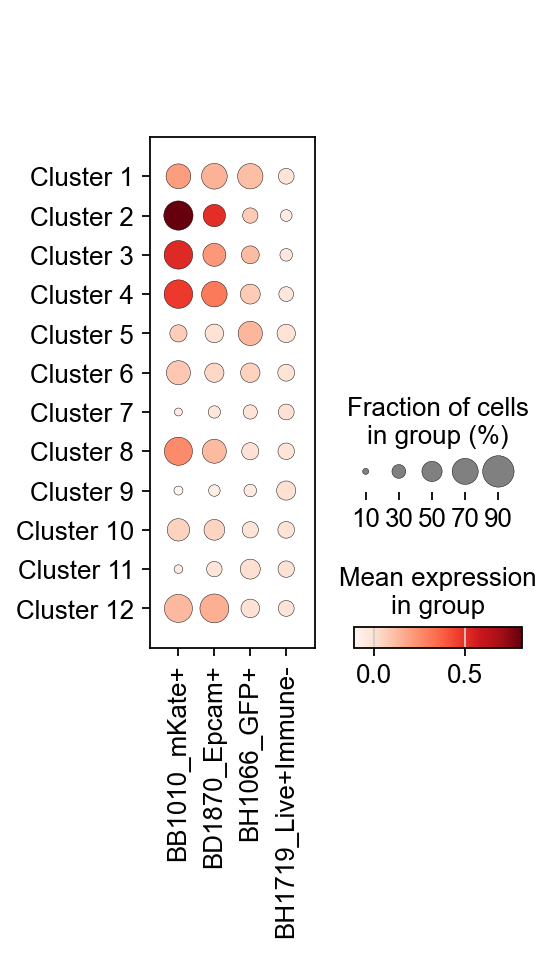

In [60]:
scoreAndPlot(adata, numgenes=100)

## Clustering the neighborhood graph

In [61]:
sc.tl.leiden(adata, resolution=0.3)

running Leiden clustering


/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/3347713724.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3)


    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


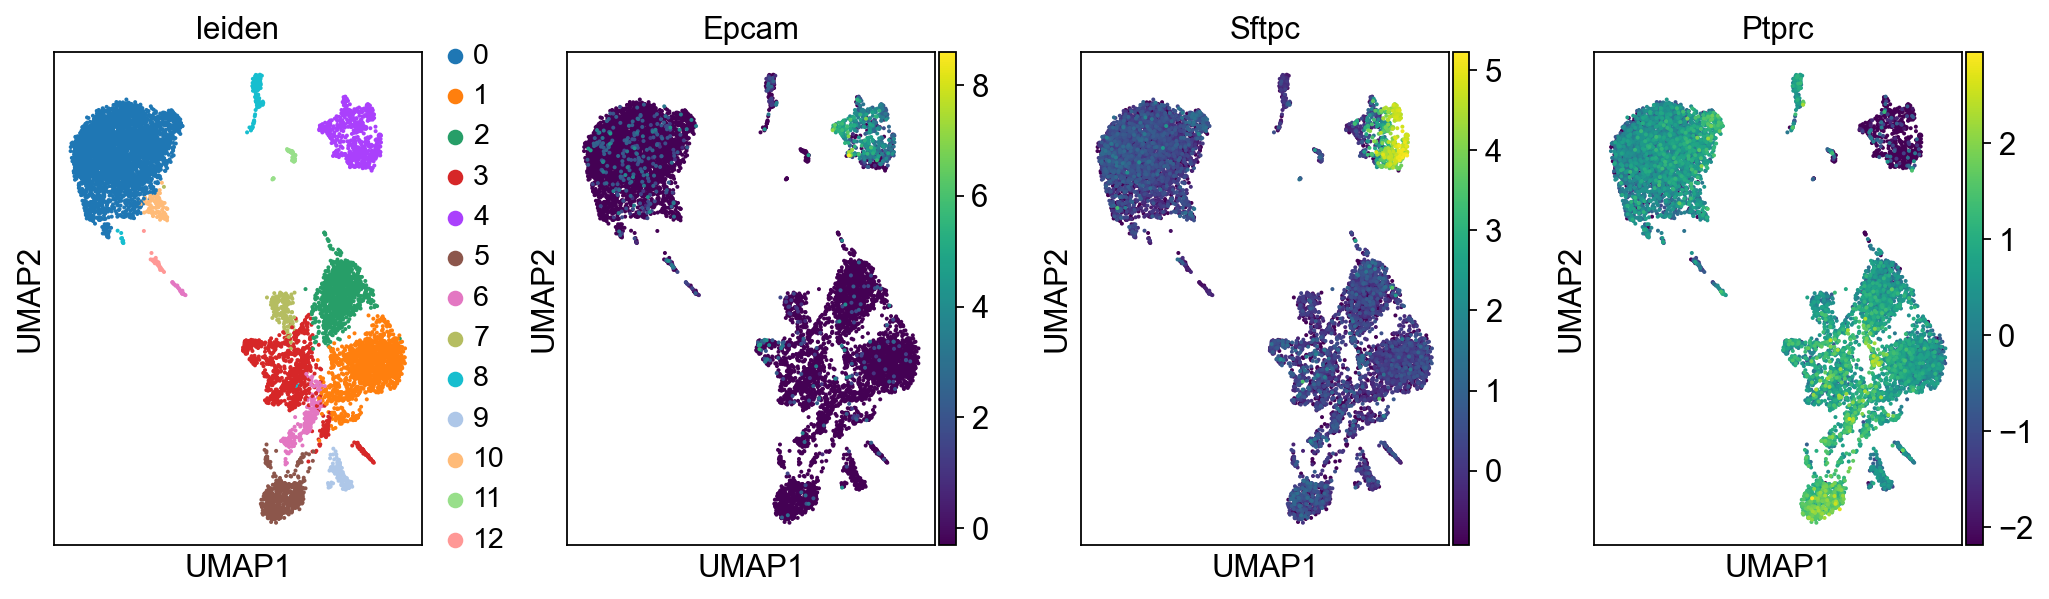

(None,)

In [62]:
sc.pl.umap(adata, color=['leiden', 'Epcam', 'Sftpc', # Tumor cells
                         'Ptprc']), #immune
                         #  'Cd4', 'Cd8a', #T cell #'Cd3e',
                         # 'Cd19', 'Ms4a1', 'Cd22', # B cell
                         # #'Itgax', 'Il3ra', # Dendritic Cell
                         # 'Ncam1',# 'Ncr1', # NK Cell
                         # 'Cd34', # Hematopoetic stem cell
                         # #'Cd14', 'Cd33', # macrophage
                         # #'Ceacam8' # Granulocyte
                         # 'Itga2b', 'Itgb3', 'Selp', #platelet
                         # #'Gypa',  # erythrocyte
                         # #'Mcam', 'Vcam1', 'Pecam1', 'Sele', # endothelial cell
                         # 'Cd109', 'Wnt5a', 'Kras'])

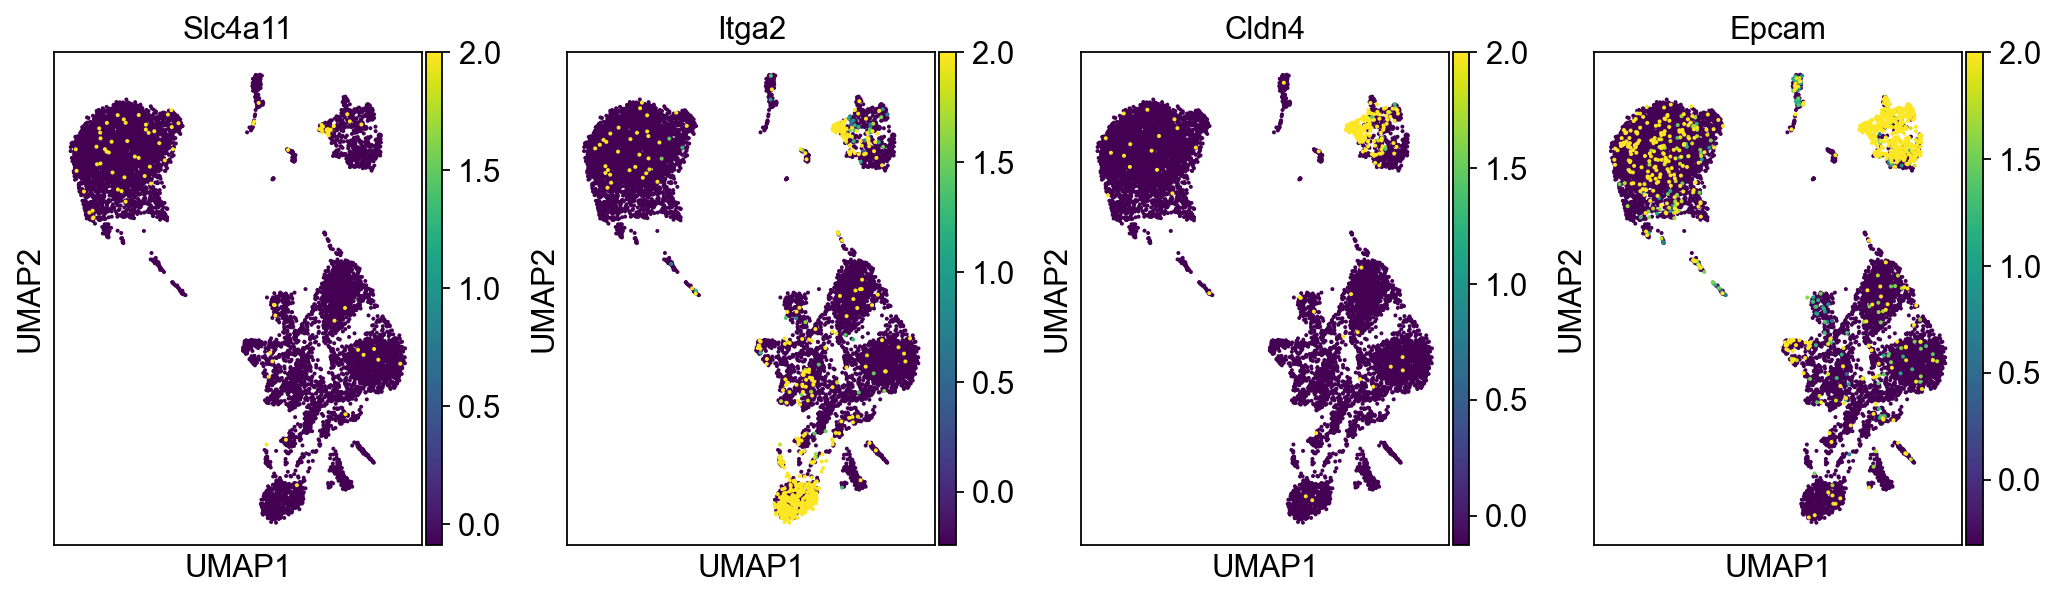

In [63]:
sc.pl.umap(adata, color=['Slc4a11', 'Itga2', 'Cldn4','Epcam'], vmax=2) #'Tigit', 

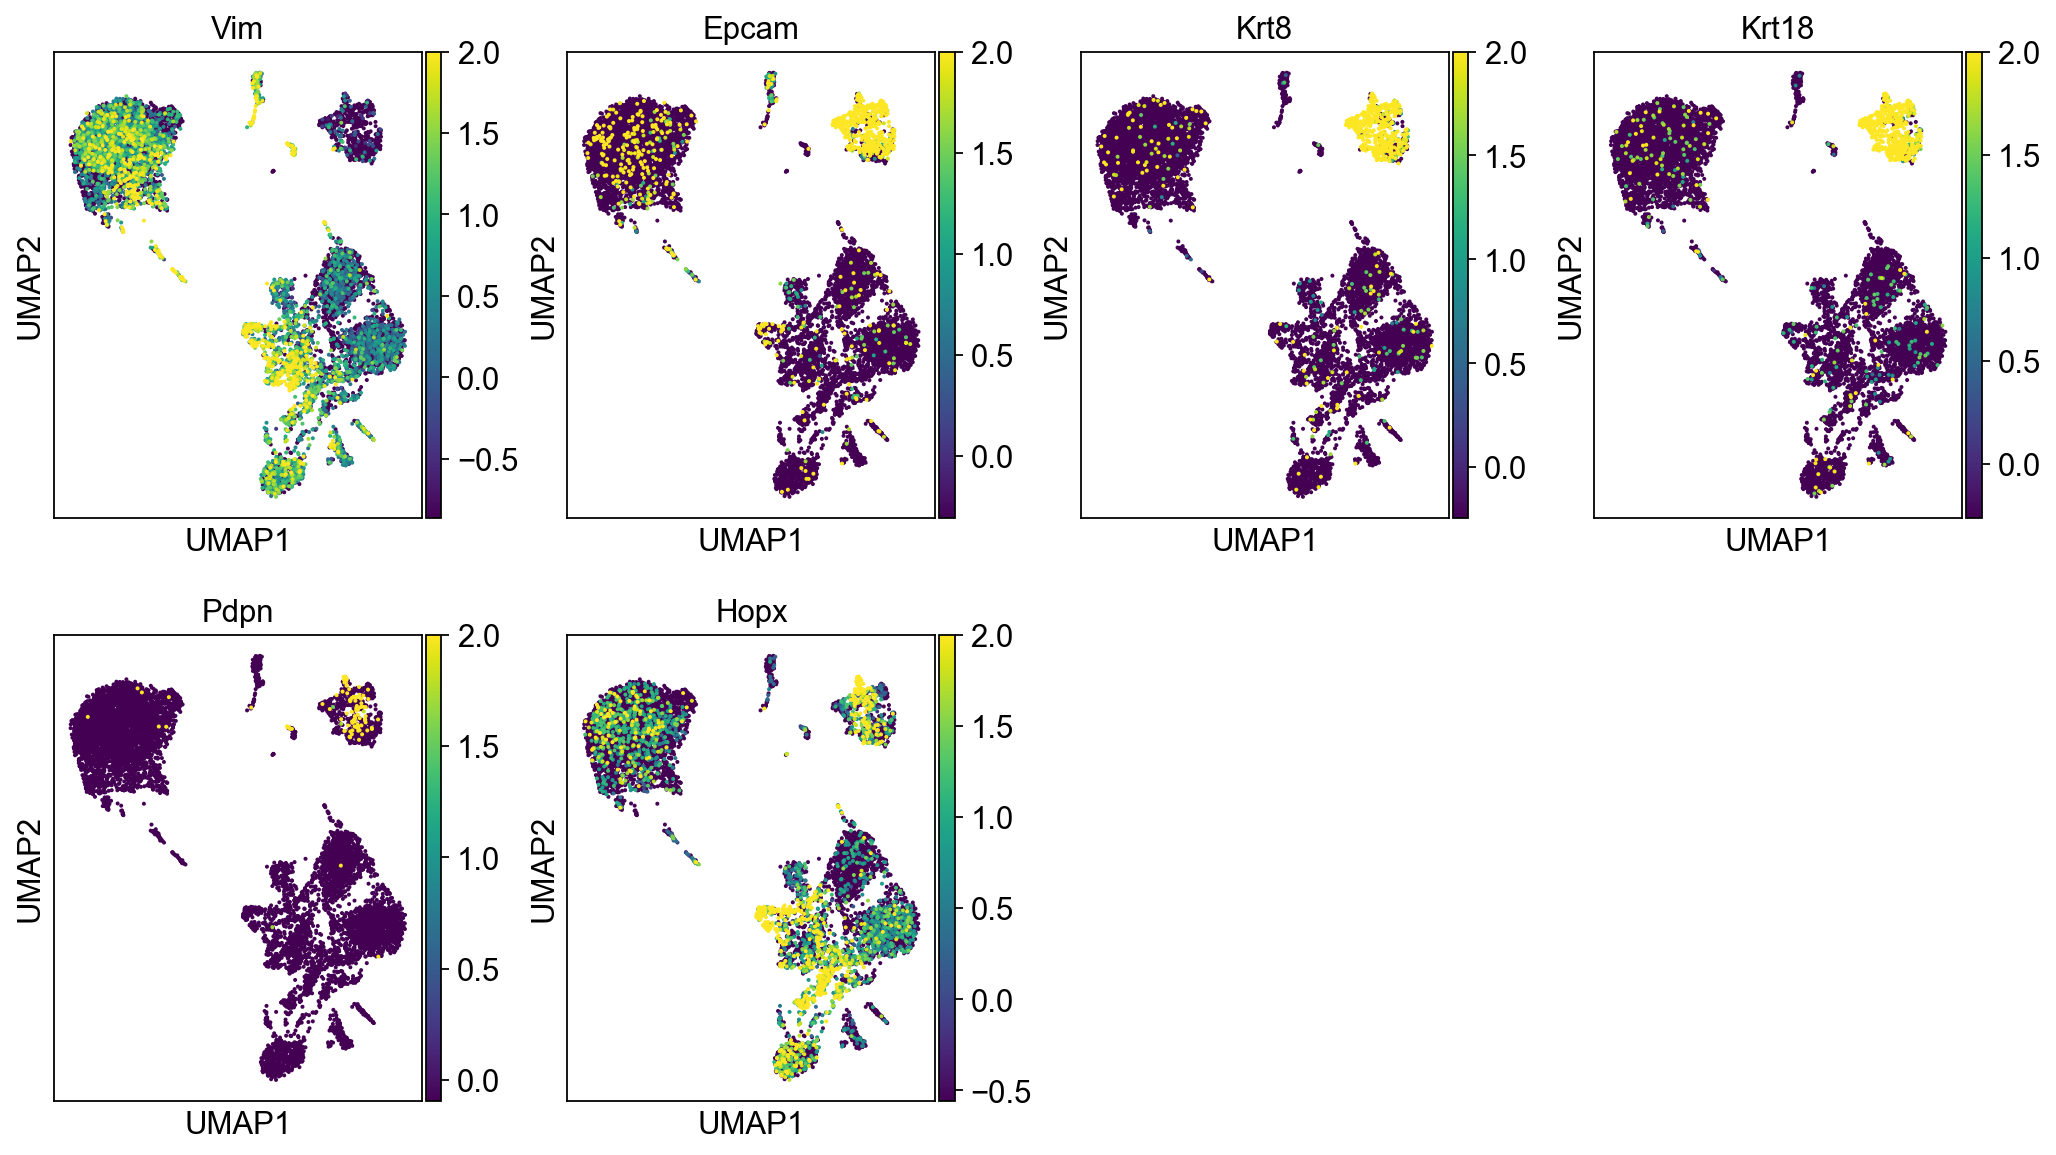

In [64]:
sc.pl.umap(adata, color=['Vim', 'Epcam', 'Krt8', 'Krt18', 'Pdpn', 'Hopx'], vmax=2) #'Pecam1',

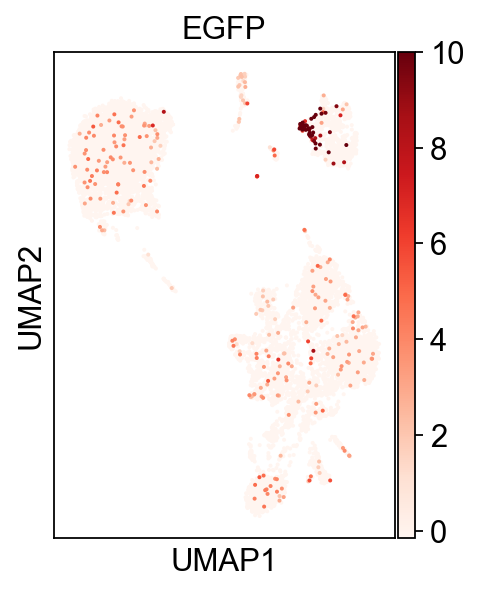

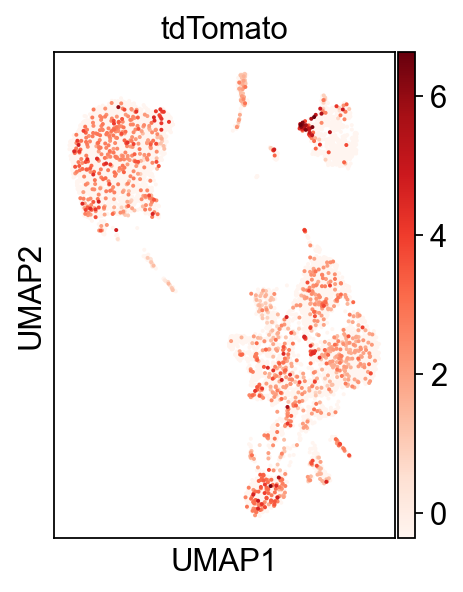

In [65]:
sc.pl.umap(adata, color=['EGFP'], cmap='Reds')
sc.pl.umap(adata, color=['tdTomato'], cmap='Reds')

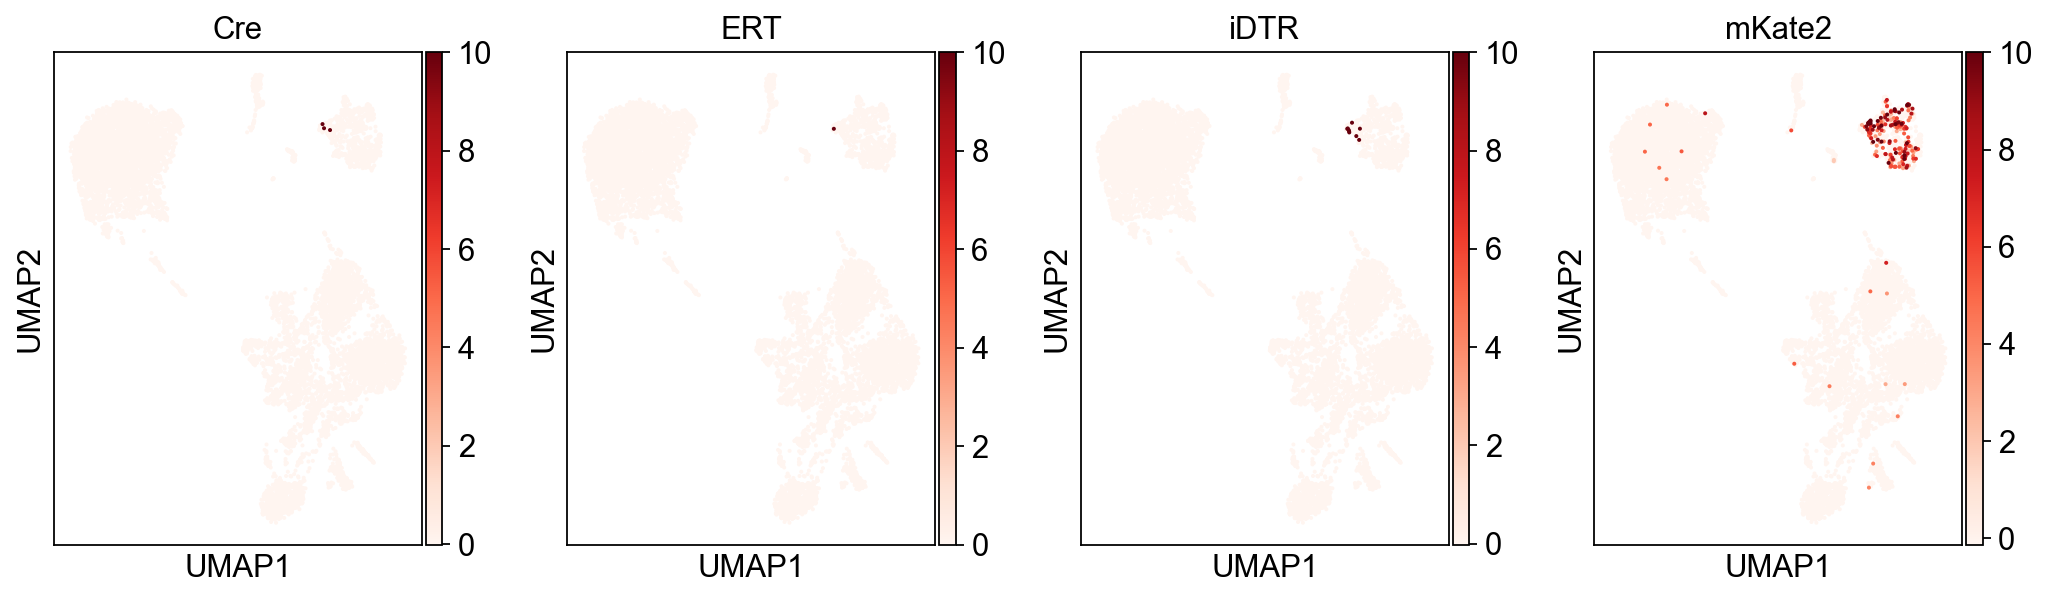

In [66]:
sc.pl.umap(adata, color=["Cre", "ERT",'iDTR','mKate2'], cmap='Reds') #"mScarlet", 

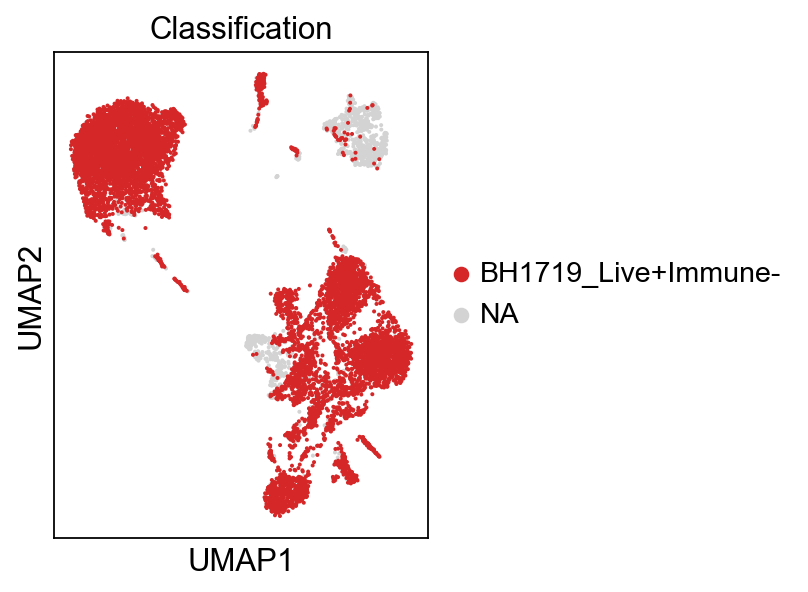

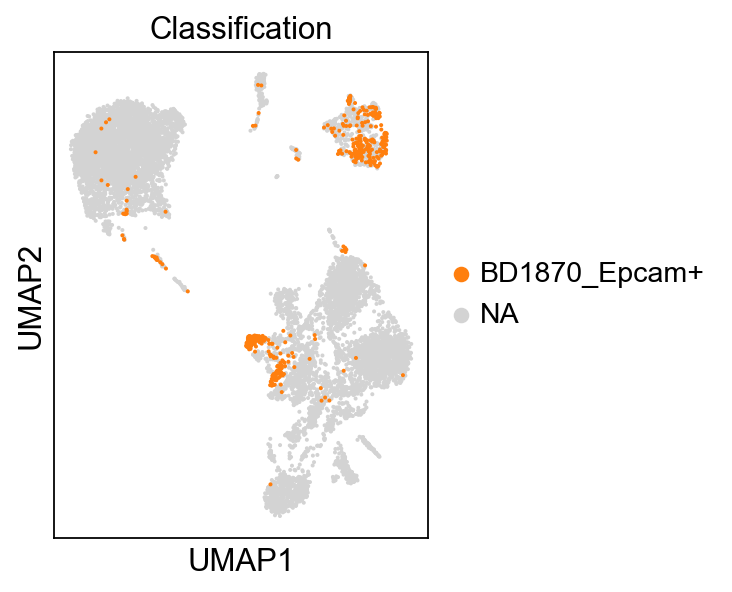

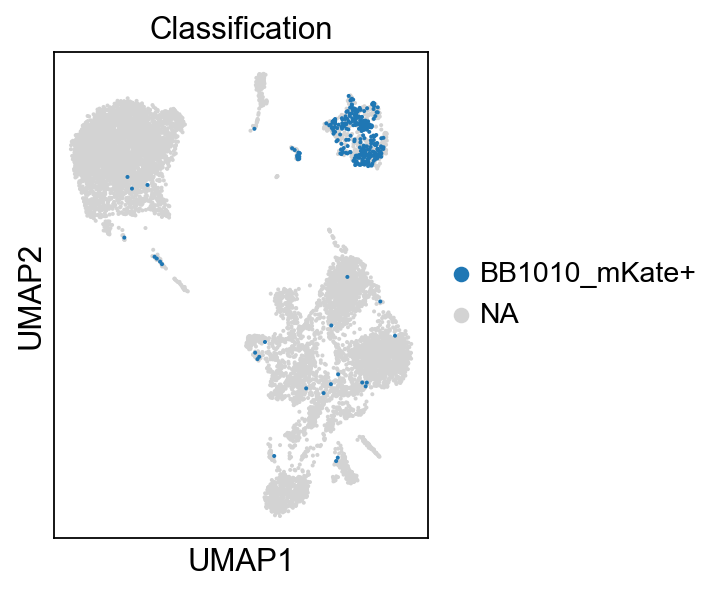

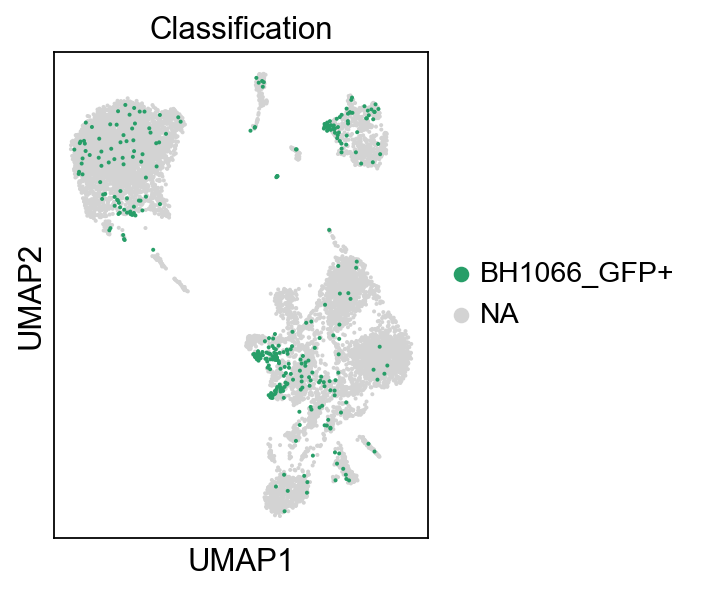

In [67]:
for label in adata.obs['Classification'].unique():
    sc.pl.umap(adata, color='Classification',groups=[label])

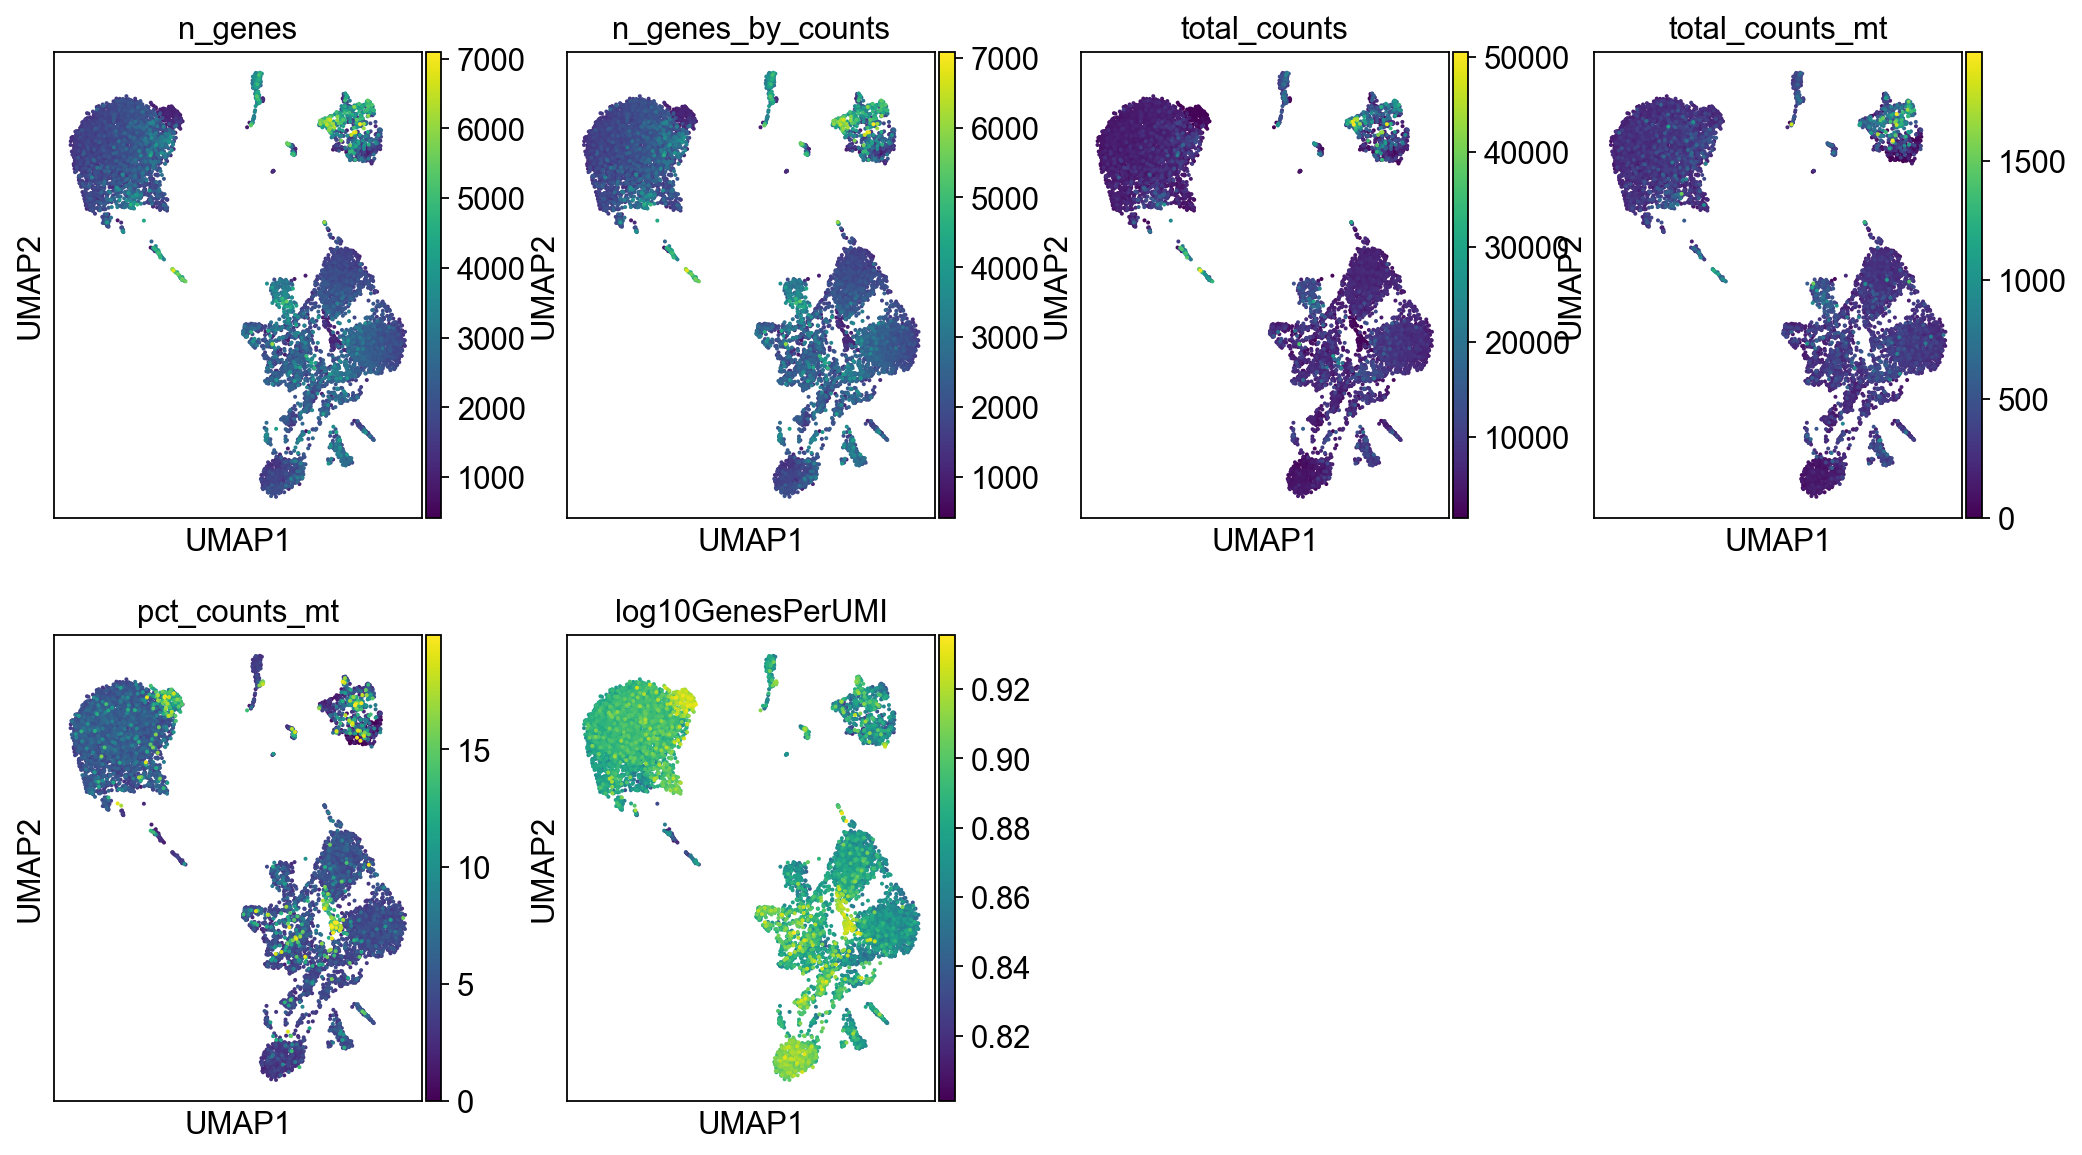

In [68]:
sc.pl.umap(adata,color=['n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'log10GenesPerUMI'])

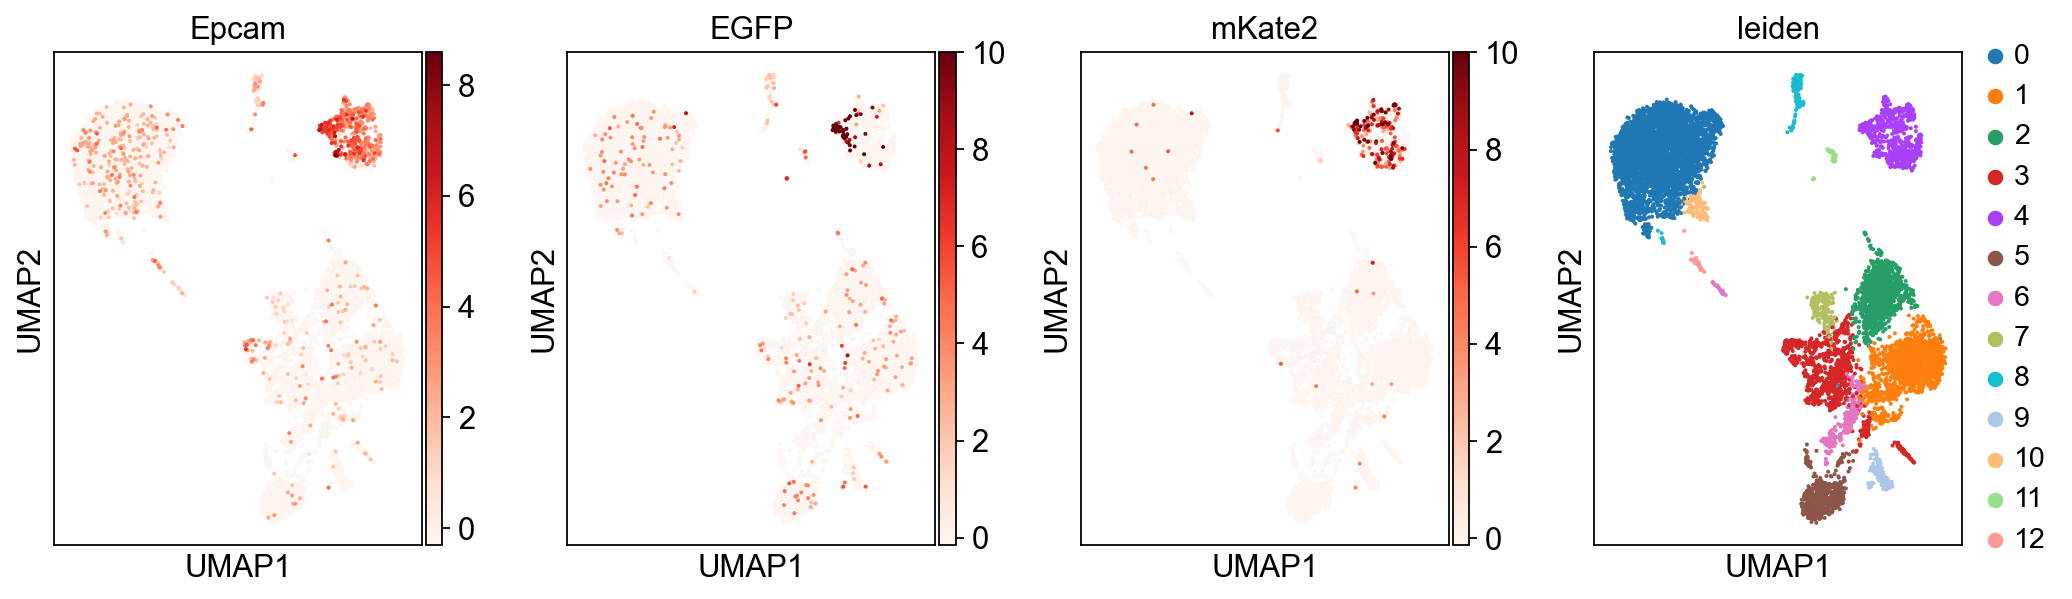

In [69]:
sc.pl.umap(adata, color=['Epcam','EGFP','mKate2','leiden'],cmap="Reds")

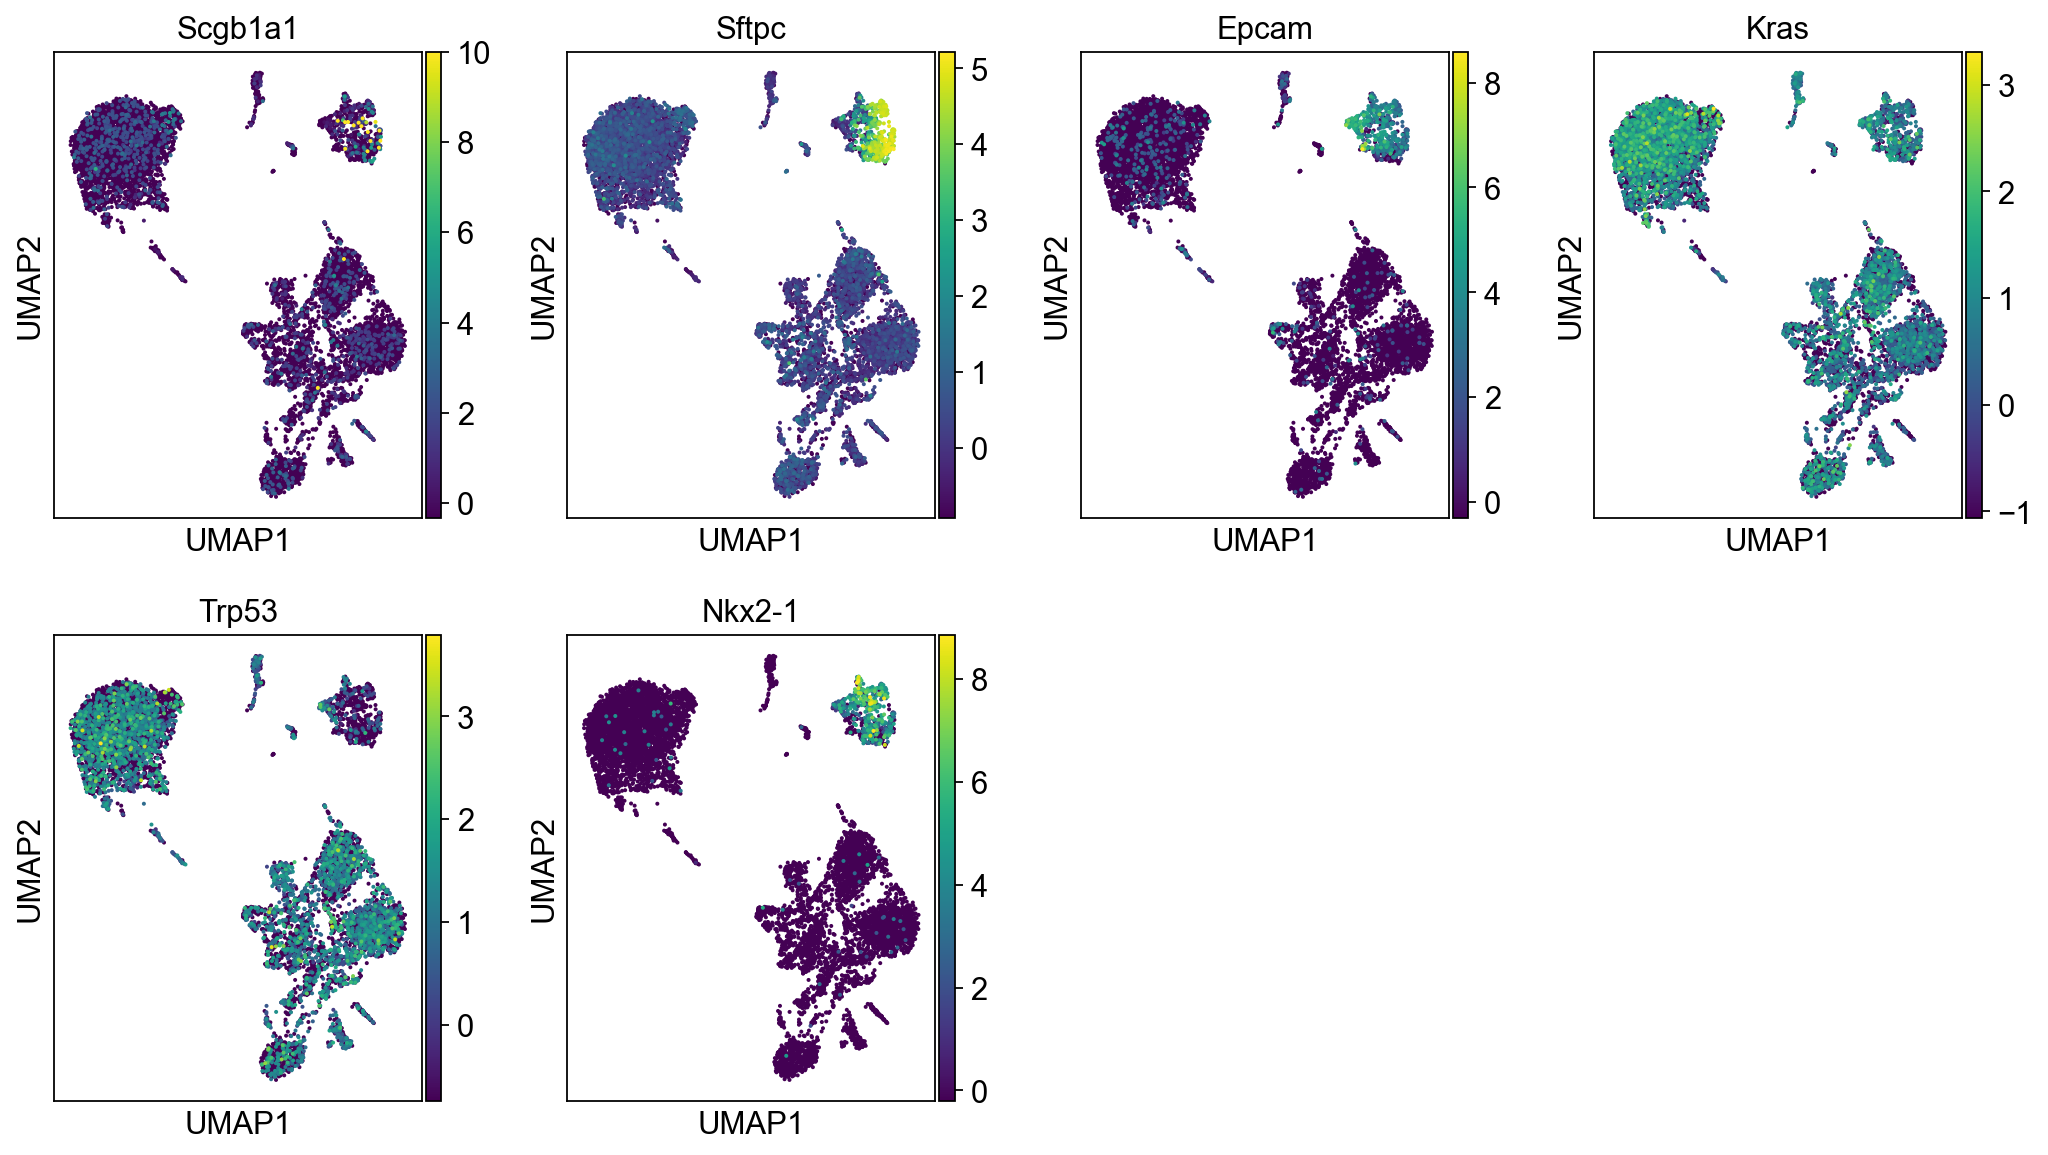

In [70]:
sc.pl.umap(adata, color=['Scgb1a1','Sftpc','Epcam','Kras', 'Trp53','Nkx2-1'])

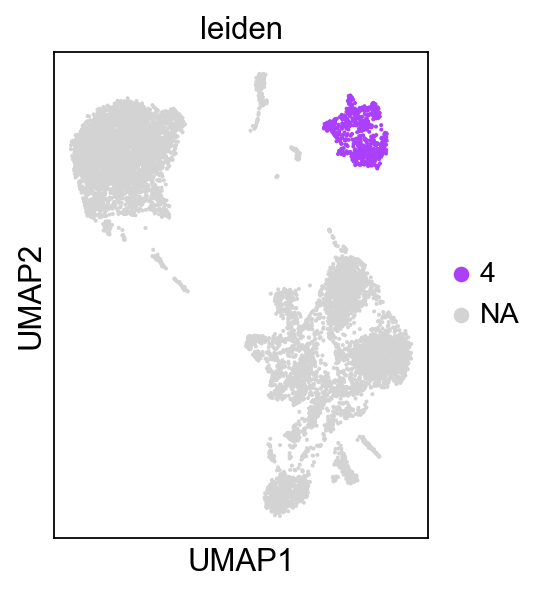

In [71]:
sc.pl.umap(adata, color=['leiden'], groups=['4'])

## Select Tumor Cells

In [72]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/allmice-IGO15771.h5ad')
adata = adata2[adata.obs['leiden'].isin(['4']),:] # keep tumor cells
del adata2

In [73]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [74]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [75]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['tagBFP'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/850513103.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/8505131

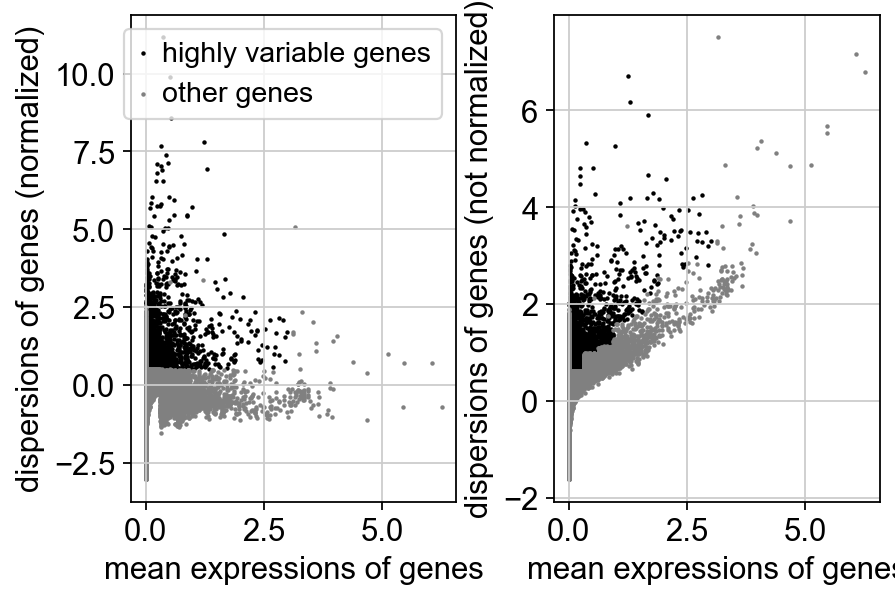

In [76]:
sc.pl.highly_variable_genes(adata)

## Now rerun algorithm

In [77]:
sc.pp.scale(adata, max_value=10)

/Users/chanj2/opt/miniconda3/envs/part1-cellrank/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## Principal component analysis

In [78]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=150)

computing PCA
    with n_comps=150
    finished (0:00:00)


In [79]:
adata.obs.Classification.value_counts()

Classification
BB1010_mKate+          263
BD1870_Epcam+          209
BH1066_GFP+             61
BH1719_Live+Immune-     39
Name: count, dtype: int64

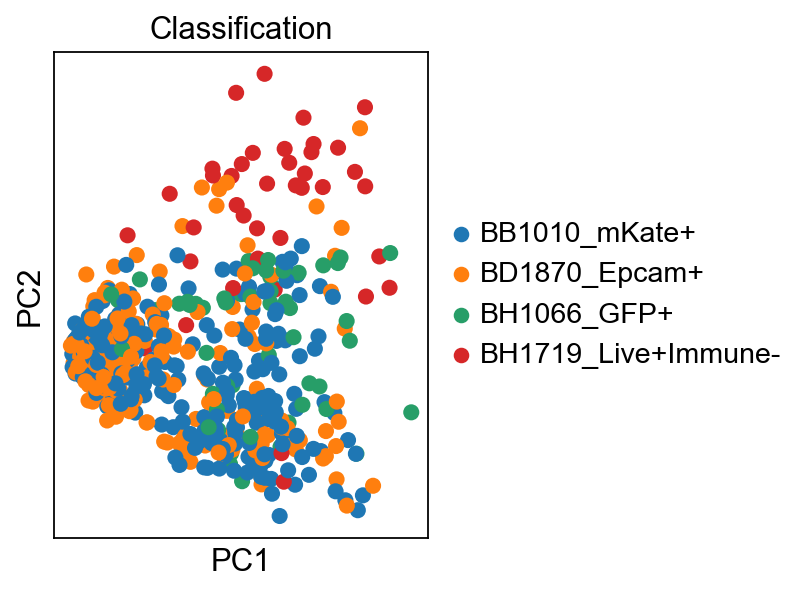

In [80]:
#sc.pl.pca(adata, color='leiden',dimensions=[(0,1)])
sc.pl.pca(adata, color='Classification',dimensions=[(0,1)])

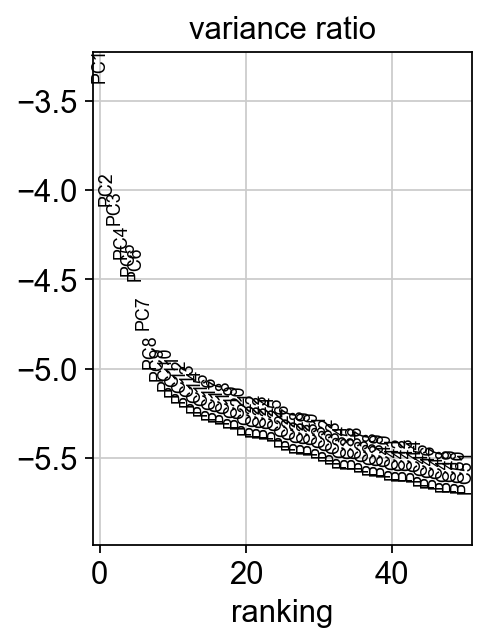

In [81]:
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)

Save the result.

In [82]:
adata.write(results_file, compression='gzip')

In [83]:
adata

AnnData object with n_obs × n_vars = 572 × 24172
    obs: 'n_counts', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'log10GenesPerUMI', 'Classification', 'EGFP_count', 'Cre_count', 'tdTomato_count'
    var: 'gene_ids', 'feature_types', 'genome', 'pattern', 'read', 'sequence', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'Classification_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [84]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


## Embedding the neighborhood graph

We suggest embedding the graph in two dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [85]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:00)


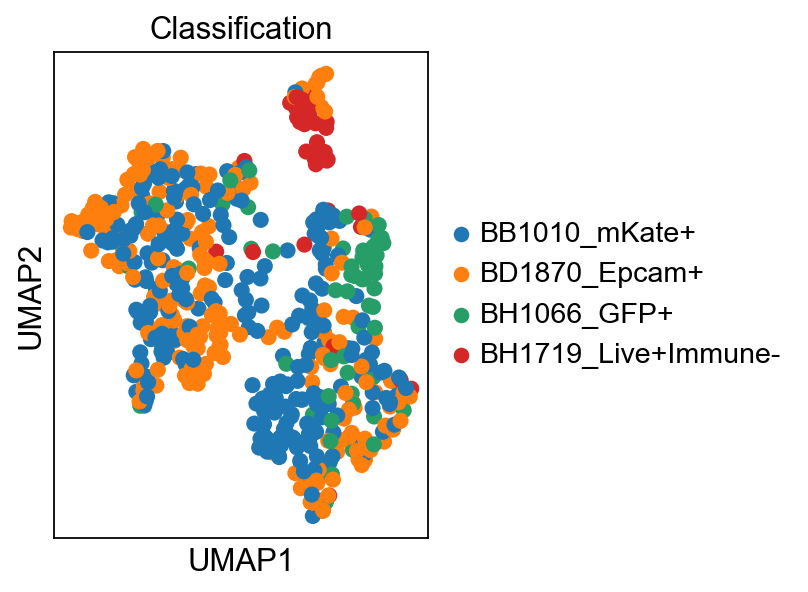

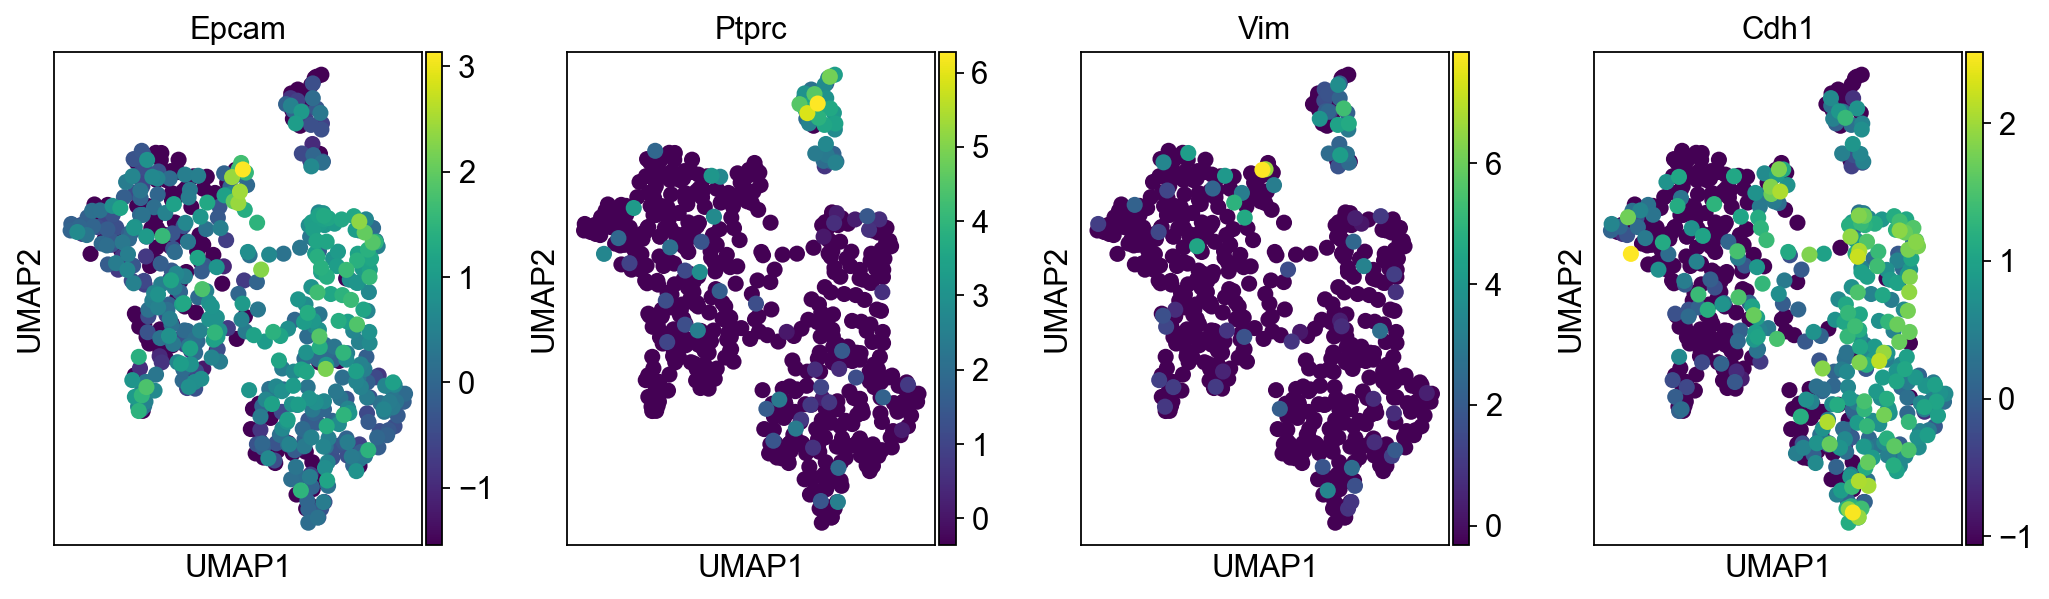

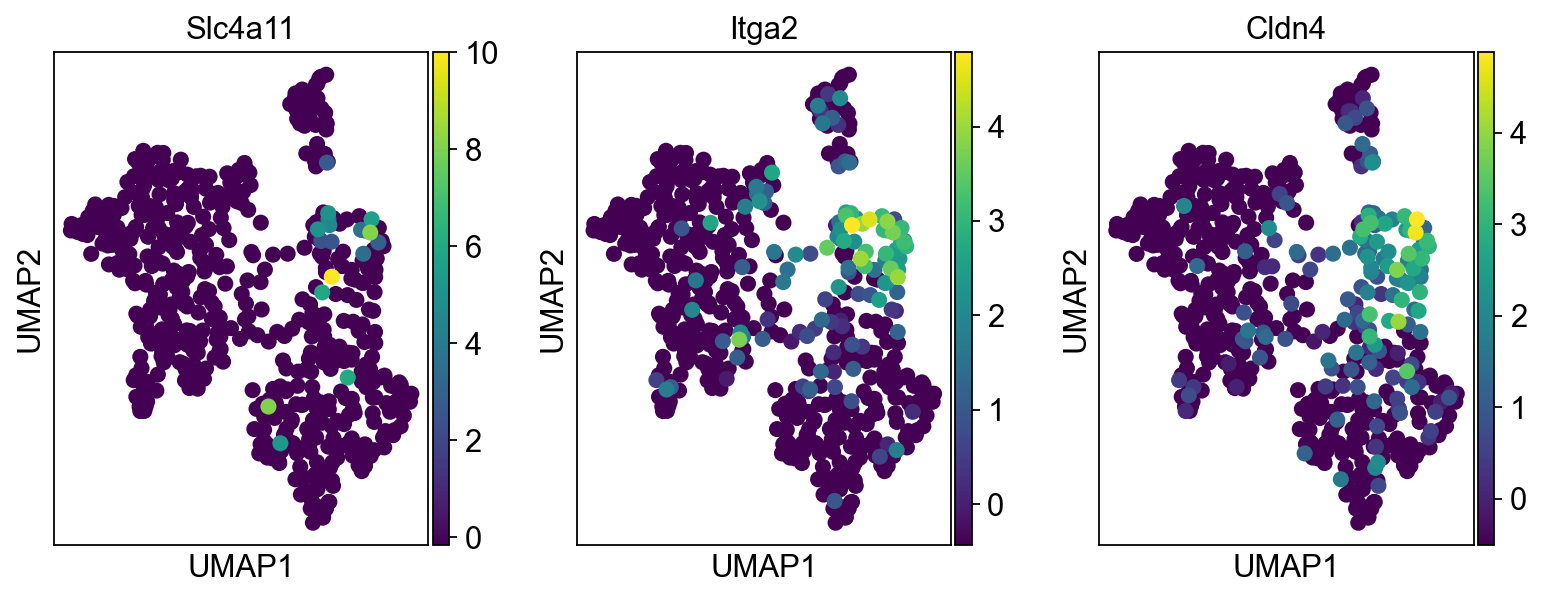

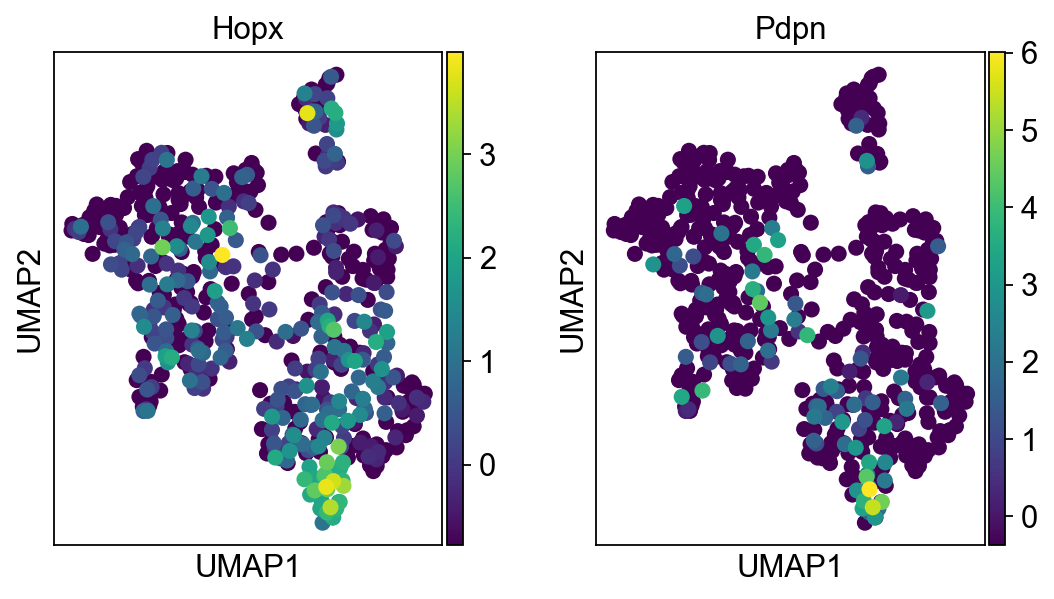

In [86]:
sc.pl.umap(adata, color=['Classification'])
#sc.pl.umap(adata, color=['Porcn', 'Lgr5', 'Lgr6','Axin2']) #LGR5 not found #
sc.pl.umap(adata, color=['Epcam', 'Ptprc', 'Vim', 'Cdh1',]) #CDH2 not found #'Cdh2'
sc.pl.umap(adata, color=['Slc4a11', 'Itga2', 'Cldn4']) #, 'Abcb1'
sc.pl.umap(adata, color=['Hopx', 'Pdpn'])
#sc.pl.umap(adata, color=['Cd81', 'Cd19'])
#sc.pl.umap(adata, color=['Trp53','Meg3'], vmax=5)

In [87]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


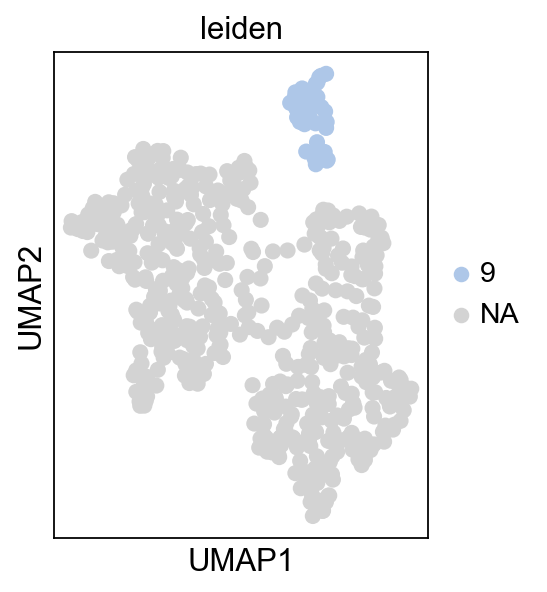

In [88]:
sc.pl.umap(adata, color=['leiden'],groups=['9'])

## Now redo analysis again to filter out Ptprc+ cluster and write tumor cells

In [89]:
# Select only those subset of cells that are useful
adata2 = sc.read('write/allmice-IGO15771.h5ad')
adata = adata2[adata[~adata.obs['leiden'].isin(['9']),:].obs.index,:] # keep tumor cells
del adata2

In [90]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = None

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/2000007.py:2: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['log1p'] = {}


In [91]:
sc.pp.highly_variable_genes(adata)#, batch_key='Classification')

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [92]:
#Ensure marker genes aren't making an impact to highly variable gene analysis downstream
adata.var.highly_variable['EGFP'] = False
adata.var.highly_variable['mScarlet'] = False
adata.var.highly_variable['Cre'] = False
adata.var.highly_variable['ERT'] = False
adata.var.highly_variable['iDTR'] = False
adata.var.highly_variable['tdTomato'] = False
adata.var.highly_variable['mKate2'] = False
adata.var.highly_variable['Akaluc'] = False
adata.var.highly_variable['GLuc'] = False
adata.var.highly_variable['CLuc'] = False
adata.var.highly_variable['tagBFP'] = False

/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/850513103.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  adata.var.highly_variable['EGFP'] = False
/var/folders/xc/wjwqs2j55dqgp2ghrn6nmlj1nlk7kz/T/ipykernel_65472/8505131

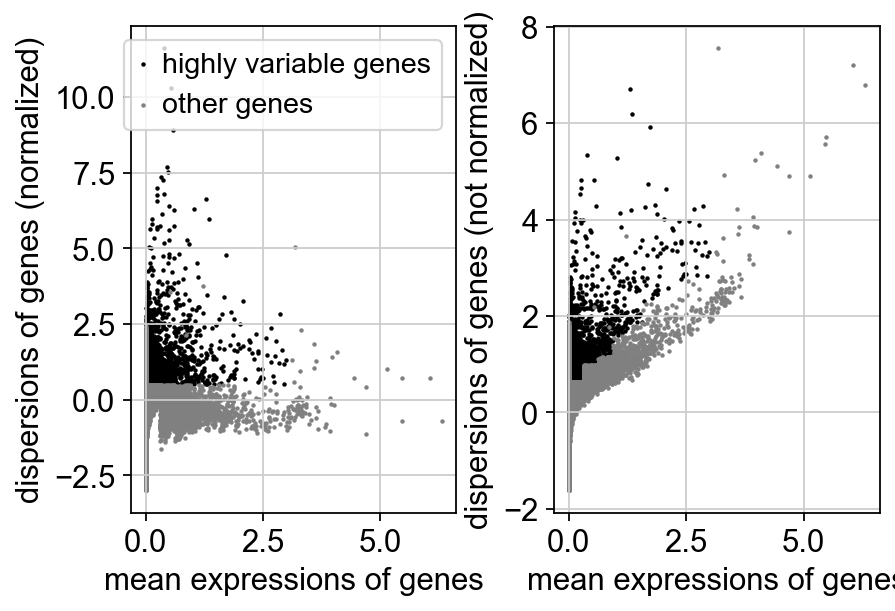

In [93]:
sc.pl.highly_variable_genes(adata)

In [94]:
adata.raw = adata

In [95]:
adata.write('write/allmice-tumor-IGO15771.h5ad', compression='gzip')
#adata = sc.read('write/allmice-tumor.h5ad')